# Intro

In [1]:
import scjpnlib.utils as scjpnutils
import os
import pandas as pd
import numpy as np
from scjpnlib.utils.file_io import FileManager
from IPython.core.display import HTML, Markdown
import matplotlib.pyplot as plt
import itertools

import json
from json_minify import json_minify
import pprint

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import scjpnlib.utils.skl_transformers as scjpnskltransformers
import scjpnlib.utils.strategy_transformers as scjpnstrattransformers
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from scjpnlib.utils import submodels as scjpnsubmodels

# leave these in until port is complete 
from scjpnlib.utils.skl_transformers import LabelEncodingTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from copy import deepcopy
import io

%load_ext autoreload
%autoreload 2

In [2]:
fm = FileManager()
preprocessing_config = fm.load_json('preprocessing-config.txt')

In [3]:
fname_unlabeled_predictors = preprocessing_config['official_data']['unlabeled_predictors']['local_fname']
fname_labeled_predictors = preprocessing_config['official_data']['labeled_predictors']['local_fname']
fname_labels = preprocessing_config['official_data']['labels']['local_fname']

ds_map = {
    fname_unlabeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'], 
    fname_labeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'],
    fname_labels: preprocessing_config['official_data']['unlabeled_predictors']['url']
}

fm.validate_download(ds_map)

In [4]:
SEED = preprocessing_config['SEED'] # for random_state reproducability

pipeline_data_preprocessor = Pipeline(steps=[('passthrough', None)], verbose=True)

In [5]:
labeled_with_target = pd.concat(
    [
        pd.read_csv(fname_labeled_predictors, index_col=0), 
        pd.read_csv(fname_labels, index_col=0)
    ], 
    axis=1
    ,
    join='inner'
).sort_index()

In [6]:
labels = labeled_with_target[['status_group']]

In [7]:
let_labels = scjpnskltransformers.LabelEncodingTransformer(['status_group'])
labels_encoded = let_labels.fit_transform(labels)

In [8]:
classes = list(let_labels.labelencoder.classes_)

In [9]:
labeled_with_target['status_group_encoded'] = labels_encoded.status_group

In [10]:
X_labeled = labeled_with_target.drop(['status_group', 'status_group_encoded'], axis=1)
X_unlabeled = pd.read_csv(fname_unlabeled_predictors, index_col=0).sort_index()

In [11]:
X_train, X_validation, y_train, y_validation = train_test_split(X_labeled.sort_index(), labels.sort_index(), test_size=preprocessing_config['test_ratio'], random_state=SEED)

In [12]:
y_train_encoded = labels_encoded.loc[y_train.index]

In [13]:
data_train = pd.concat([X_train, y_train, y_train_encoded], axis=1, join='inner').sort_index()
data_train.columns = list(X_train.columns) + ['status_group', 'status_group_encoded']

In [14]:
y_validation_encoded = labels_encoded.loc[y_validation.index]

In [15]:
data_validation = pd.concat([X_validation, y_validation, y_validation_encoded], axis=1, join='inner').sort_index()
data_validation.columns = list(X_validation.columns) + ['status_group', 'status_group_encoded']

<p><br>

## Summary of Preprocessing Options and Brute-force (Bad) Complexity

In [16]:
cartesian_prod = 1
brute_force_complexity = []
n_exp = 0
for feat_group_name in preprocessing_config['feature_groupings']:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']

    features = preprocessing_config['feature_groupings'][feat_group_name]['features']

    display(HTML(f"<b>{feat_group_name}</b> feature-group has {len(features)} features ({features}) handled across {len(preprocessing_options)} preprocessing groups:"))

    # print(eda_config['feature_groupings'][feat_group_name]['preprocessing_options'])
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        n_exp += 1
        brute_force_complexity.append((preprocessing_group_name, opts_for_group))

        display(HTML(f"{scjpnutils.helper__HTML_tabs(1)}preprocessing group <b>{preprocessing_group_name}</b> has {len(opts_for_group)} preprocessing options"))
        cartesian_prod *= len(opts_for_group)

        for idx, preprocessing_option in enumerate(opts_for_group):
            display(HTML(f"{scjpnutils.helper__HTML_tabs(2)}option {idx+1}: {preprocessing_option}"))

        display(HTML("<p>"))

    display(HTML("<p><br>"))

s_brute_force_complexity = '\\times '.join(['|'+t_ppg_ofg[0]+'|' for t_ppg_ofg in brute_force_complexity])
s_brute_force_complexity = f"$O({s_brute_force_complexity}) \\in O(n^" + "{" + f"{n_exp}" + "})$"
display(Markdown(f"brute-force complexity: {s_brute_force_complexity}"))

# s_list_of_preprocessing_groups = pprint.pformat(list_of_preprocessing_groups, indent=4)
# print(f"\nlist of feat-preprocessing-options:\n{s_list_of_preprocessing_groups}")

display(Markdown(f"In our case, this would amount to {cartesian_prod} iterations doing it the brute-force way!)"))
# cartesian_prod = list(itertools.product(*list_of_preprocessing_groups)) # DO NOT UNCOMMENT THIS!  THIS TAKES A VERY LONG TIME TO COMPUTE.  IT IS ONLY HERE FOR REFERENCE.
# print(f"\n\nsize of cartesian-product (itertools): {len(cartesian_prod)}")

brute-force complexity: $O(|extraction_type|\times |extraction_type_group|\times |extraction_type_class|\times |amount_tsh|\times |source|\times |source_type|\times |source_class|\times |quantity|\times |quantity_group|\times |water_quality|\times |quality_group|\times |gps_height|\times |gps_coordinates|\times |waterpoint_type|\times |waterpoint_type_group|\times |installer|\times |population|\times |geographic_location|\times |subvillage|\times |wpt_operator|\times |pump_age|\times |payment_type|\times |payment|\times |num_private|\times |wpt_name|\times |basin|\times |public_meeting|\times |recorded_by|\times |permit|\times |management|\times |management_group|\times |funder|) \in O(n^{32})$

In our case, this would amount to 236760072192 iterations doing it the brute-force way!)

You read that correctly: if we do this using brute-force, that would require building (transforming) a virtually uncountable number of data sets.

That is obviously intractible.  

Consider the case when transforming and building a model on X_train and predicting on X_validation takes, on average, 1 minute.

There are 525600 minutes in one year.

In [17]:
display(HTML(f"Doing it the brute-force way (the space of all possible combinations of preprocessing options) would require about {int((cartesian_prod/525600)/100)} CENTURIES!!! LOL!"))

Instead, we will use a Greedy Algorithm to turn this into a linear problem.

## Baselining the Greedy Way - Another Exercise in Dynamic Programming

The idea goes like this:

1. Build a baseline model using the most features possible - since a lot of features contains `nan` values, this precludes the use of `DecisionTreeClassifier` and `RandomForestClassifier` for baselining; thus, we will baseline using `XGBClassifier` since it allows `nan`s.
2. From there, we will try out each option for each feature-group (specified in the config) - to be clear, we will include the baseline features plus those involved in the particular preprocessing option.
3. Build a model (with `XGBClassifier`) and compare its validation accuracy to the validation accuracy of the baseline model - if it goes down or stays the same, this obviously is not a good preprocessing option to keep; if it goes up from the baseline, then we will obviously keep this preprocessing option; we will keep the option that garners the best improvement on a per-feature-group basis.

### Build Baseline Model

We use this as a basis for comparison to demonstrate iterative permformance when examine available preprocessing options for a given feature-group.

The idea is to use a classifier that is flexible enough to deal with as many of the features from the untouched training data set.  As we have seen, there are plenty of null/missing values in the raw data set.  So we want a classifier that can readily handle nulls.  That rules out using `DecisionTreeClassifier` or `RandomForestClassifier` for our baseline model.  `XGBClassifier`, on the other hand, can handle `nan`s just fine.  So we will use it to build our baseline and inspect various preprocessing options using it.

However, for `XGBClassifier`, values it models must be an `int`, `float`, or `bool`.

Thus, we need to filter out any features that are not of that type.

In [18]:
X_train_baseline = X_train.select_dtypes(['number', 'bool'])
baseline_cols = sorted(list(X_train_baseline.columns))
baseline_cols

['amount_tsh',
 'construction_year',
 'district_code',
 'gps_height',
 'latitude',
 'longitude',
 'num_private',
 'population',
 'region_code']

In [19]:
X_train_baseline = X_train_baseline[baseline_cols]
X_train_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         53460 non-null  float64
 1   construction_year  53460 non-null  int64  
 2   district_code      53460 non-null  int64  
 3   gps_height         53460 non-null  int64  
 4   latitude           53460 non-null  float64
 5   longitude          53460 non-null  float64
 6   num_private        53460 non-null  int64  
 7   population         53460 non-null  int64  
 8   region_code        53460 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


In [20]:
X_validation_baseline = X_validation[baseline_cols]

In [21]:
def summarize_preds(clf, X, y, preds, dataset_name, classes):
    display(HTML("<p><br>"))
    _accuracy = accuracy_score(y, preds)
    display(HTML(f"{dataset_name} Accuracy: {round(_accuracy*100,4)}"))
    display(HTML("<p><br>"))
    display(HTML(f"<pre>{classification_report(y, preds, target_names=classes)}</pre>"))
    return _accuracy

In [22]:
clf = XGBClassifier(max_depth=20, gamma=1, random_state=SEED, n_jobs=-1)
clf.fit(X_train_baseline, y_train_encoded.status_group)

pred_validation_baseline = clf.predict(X_validation_baseline)
_accuracy_validation_baseline = summarize_preds(clf, X_validation_baseline, y_validation_encoded.status_group, pred_validation_baseline, 'Validation', classes)

### Iterate each preprocessing option (from config file), apply, compare results to Baseline - Keep the options that increase accuracy over Baseline

In [23]:
# the key, the heart of the algo...
def find_best_option(feature_group_name, preprocessing_group_name, best_options, y_acc):
    display(HTML(f"<h2 style='background-color: yellow;'>Finding best option for feature group <i>{feature_group_name}</i>, preprocessing group <i><font color='red'>{preprocessing_group_name}</font></i> after baseline...</h2>"))

    best = None
    preprocessing__group_options = preprocessing_config['feature_groupings'][feature_group_name]['preprocessing_options'][preprocessing_group_name]

    X_train_priors_transformed = X_train.copy()

    pipeline_priors = deepcopy(pipeline_data_preprocessor)
    
    cols_prior = []
    
    _y_acc = []

    # apply best options already found preceding this one
    if len(best_options) > 0:
        display(HTML(f"<h3 style='background-color: yellow;'>Transforming X with PRIOR best options...</h3>"))
        
        # include (best) results found previously
        for prior_best_option in best_options:
            composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
                prior_best_option[1], 
                prior_best_option[0],
                pipeline_priors
            )
            scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
            X_train_priors_transformed = composite_transformer.fit_transform(X_train_priors_transformed, y_train_encoded.status_group)

            # get list of cols transformed by this option
            transformed_cols = []
            scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
            transformed_cols = set(transformed_cols)
            
            # filter out any columns that were dropped
            filtered_baseline_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), baseline_cols)))
            display(HTML(f"<h4>baseline features in X after this transformation:</h4>"))
            display(HTML(f"<pre>{filtered_baseline_cols}</pre>"))
            
            # only include cols in filtered_transformed_feat_names not already in filtered_baseline_cols
            cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols = transformed_cols - set(filtered_baseline_cols)
            prior_cols_transformed_not_in_filtered_baseline_cols = set(cols_prior) - set(filtered_baseline_cols)
            # now we need to filter out the ones not in X
            filtered_prior_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), prior_cols_transformed_not_in_filtered_baseline_cols)))
            filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols, transformed_cols)))
            filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), filtered_transformed_feat_names)))
            filtered_transformed_feat_names = filtered_prior_cols + filtered_transformed_feat_names
            display(HTML(f"<h4>features (not in baseline) in X after transformation (including best priors):</h4>"))
            display(HTML(f"<pre>{filtered_transformed_feat_names}</pre>"))
            
            baseline_plus_transformed_cols = filtered_baseline_cols
            if len(filtered_transformed_feat_names) > 0:
                baseline_plus_transformed_cols.extend(filtered_transformed_feat_names)
                
            cols_prior = baseline_plus_transformed_cols
            display(HTML(f"<h4>features included from prior best modes:</h4>"))
            buffer = io.StringIO()
            X_train_priors_transformed[cols_prior].info(buf=buffer)
            s_info = buffer.getvalue()
            display(HTML(f"<pre>{s_info}</pre>"))
            
        display(HTML(f"<h4>terminal features in prior best model:</h4>"))
        buffer = io.StringIO()
        X_train_priors_transformed[cols_prior].info(buf=buffer)
        s_info = buffer.getvalue()
        display(HTML(f"<pre>{s_info}</pre>"))
    
    # iterate through options to find best result
    for idx, preprocessing_option in enumerate(preprocessing__group_options):
        pipeline_temp = deepcopy(pipeline_priors)
        cols_in_model = []

        display(HTML(f"<h3 style='background-color: yellow;'>Transforming X with option {idx+1}:</h3>"))
        composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
            preprocessing_option, 
            preprocessing_group_name,
            pipeline_temp
        )
        scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
        X_train_transformed = composite_transformer.fit_transform(X_train_priors_transformed.copy(), y_train_encoded.status_group)
        
        # get list of cols transformed by this option
        transformed_cols = []
        scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
        transformed_cols = set(transformed_cols)
        
        # filter out any columns that were dropped
        filtered_baseline_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), baseline_cols)))
        display(HTML(f"<h4>baseline features in X after this transformation:</h4>"))
        display(HTML(f"<pre>{filtered_baseline_cols}</pre>"))
        
        # only include cols in filtered_transformed_feat_names not already in filtered_baseline_cols
        cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols = transformed_cols - set(filtered_baseline_cols)
        prior_cols_transformed_not_in_filtered_baseline_cols = set(cols_prior) - set(filtered_baseline_cols)
        # now we need to filter out the ones not in X
        filtered_prior_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), prior_cols_transformed_not_in_filtered_baseline_cols)))
        filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols, transformed_cols)))
        filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), filtered_transformed_feat_names)))
        filtered_transformed_feat_names = filtered_prior_cols + filtered_transformed_feat_names
        display(HTML(f"<h4>features (not in baseline) in X after transformation (including best priors):</h4>"))
        display(HTML(f"<pre>{filtered_transformed_feat_names}</pre>"))
        
        baseline_plus_transformed_cols = filtered_baseline_cols
        if len(filtered_transformed_feat_names) > 0:
            baseline_plus_transformed_cols.extend(filtered_transformed_feat_names)

        cols_in_model.extend(baseline_plus_transformed_cols)
        display(HTML(f"<h4>features to be included in model:</h4>"))
        buffer = io.StringIO()
        X_train_transformed[cols_in_model].info(buf=buffer)
        s_info = buffer.getvalue()
        display(HTML(f"<pre>{s_info}</pre>"))

        if len(cols_in_model) > 0:
            display(HTML(f"<h4>Building model on X transformed with current option...</h4>"))
            X_train_transformed = X_train_transformed[cols_in_model]
            clf = XGBClassifier(max_depth=20, gamma=1, random_state=SEED, n_jobs=-1)
            clf.fit(X_train_transformed, y_train_encoded.status_group)

            display(HTML(f"<h4>Transforming validation set with current option...</h4>"))
            X_validation_transformed = pipeline_temp.transform(X_validation) 
            X_validation_transformed = X_validation_transformed[cols_in_model]

            display(HTML(f"<h4>Using model to predict y's on validation set...</h4>"))
            pred_validation = clf.predict(X_validation_transformed)
            _accuracy_validation = summarize_preds(clf, X_validation_transformed, y_validation_encoded.status_group, pred_validation, 'Validation', classes)
            
            _y_acc.append(_accuracy_validation)

            if best is None or _accuracy_validation > best[3]:
                best = (preprocessing_group_name, preprocessing_option, cols_in_model, _accuracy_validation)
                display(HTML(f"<h4 style='background-color: yellow;'><i>Option {idx+1}</i> yields new BEST-IN-GROUP validation accuracy.</h4>"))
        else:
            display(HTML(f"<h4><font color='red'>COULD NOT BUILD MODEL AS THERE ARE NO FEATURES TO BE INCLUDED!</font></h4>"))
        
        
        display(HTML("<p><br><br><br><br>"))
        
    y_acc.append({'ppgn': preprocessing_group_name, 'acc': _y_acc})

    if best[3] <= _accuracy_validation_baseline:
        display(HTML(f"<h2><font color='red'>NO OPTION INCREASES ACCURACY ABOVE BASELINE ({_accuracy_validation_baseline})!</font></h2>"))
    else:
        display(HTML(f"<h2><font color='green'>Best option increases accuracy to {best[3]} ABOVE BASELINE ({_accuracy_validation_baseline}):</font></h2>"))
        display(HTML(f"<pre>{(best[0], best[1], best[3])}</pre>"))

    return best, y_acc

In [24]:
# # test out individual preprocessing groups here, for example...
best_options = []
y_acc = []
# find_best_option('installer__group', 'installer', best_options, y_acc)
# find_best_option('funder__group', 'funder', best_options, y_acc)
# find_best_option('pump_age_at_observation_date__group', 'pump_age', best_options, y_acc)
# find_best_option('geographic_location__group', 'ward', best_options, y_acc)
# find_best_option('num_private__group', 'num_private', best_options, y_acc)
# find_best_option('wpt_operator__group', 'wpt_operator', best_options, y_acc)
# find_best_option('gps_coordinates__group', 'gps_coordinates', best_options, y_acc)

strategy appended step ['drop feature: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b4ccd0>] to pipeline
strategy "drop feature: extraction_type" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b4ab00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeb5f5110>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


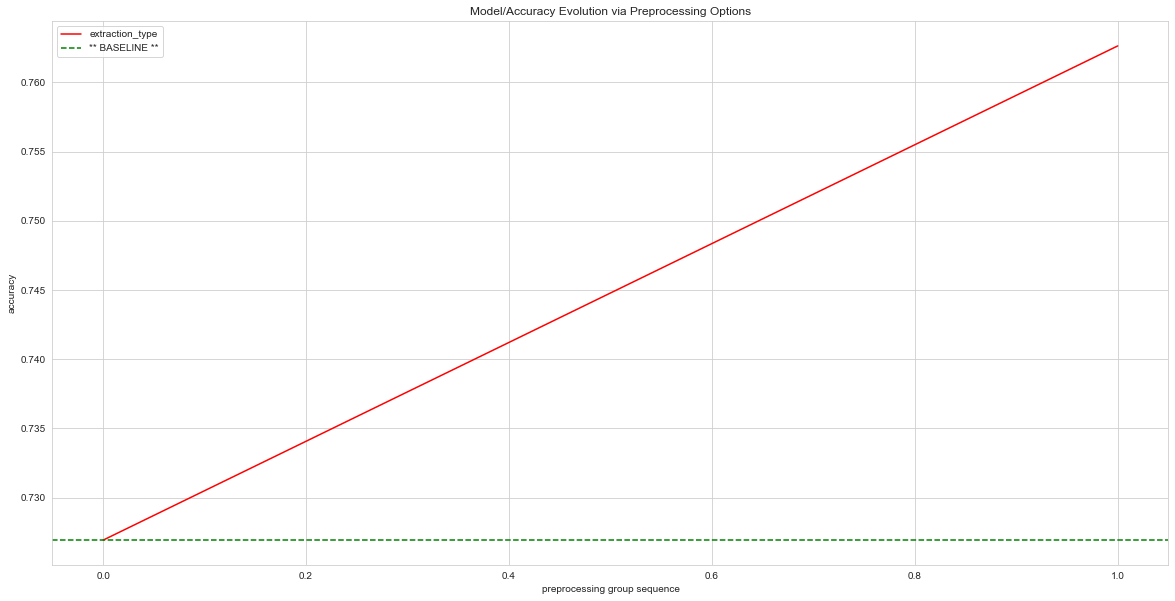

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed80324d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8051710>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fef02b01b10>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


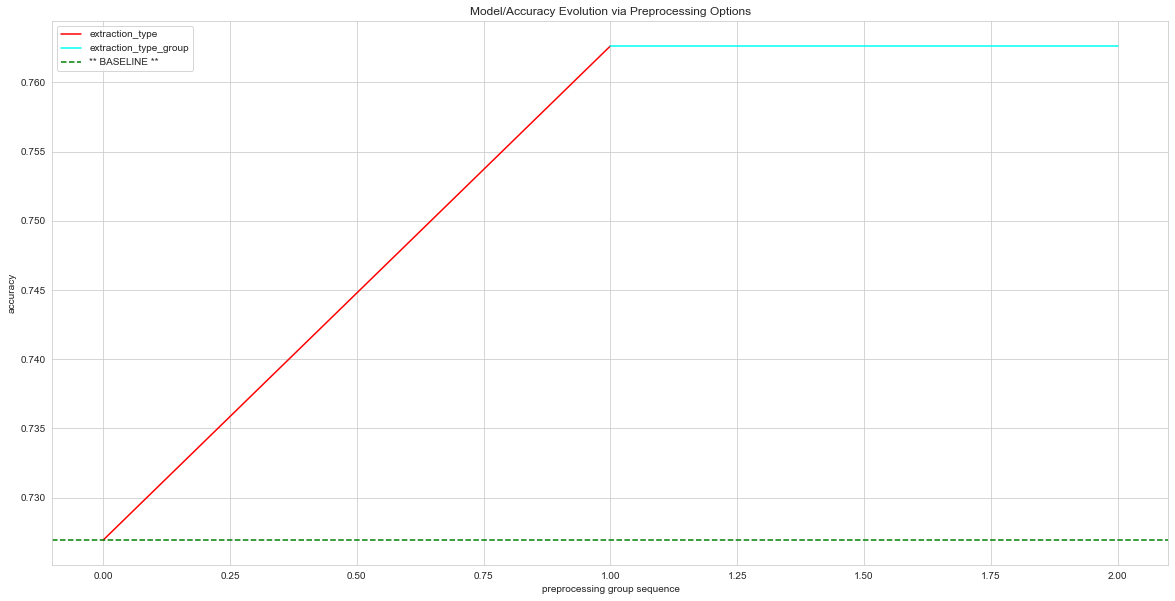

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4c830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8051510>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c34d10>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7ff5110>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


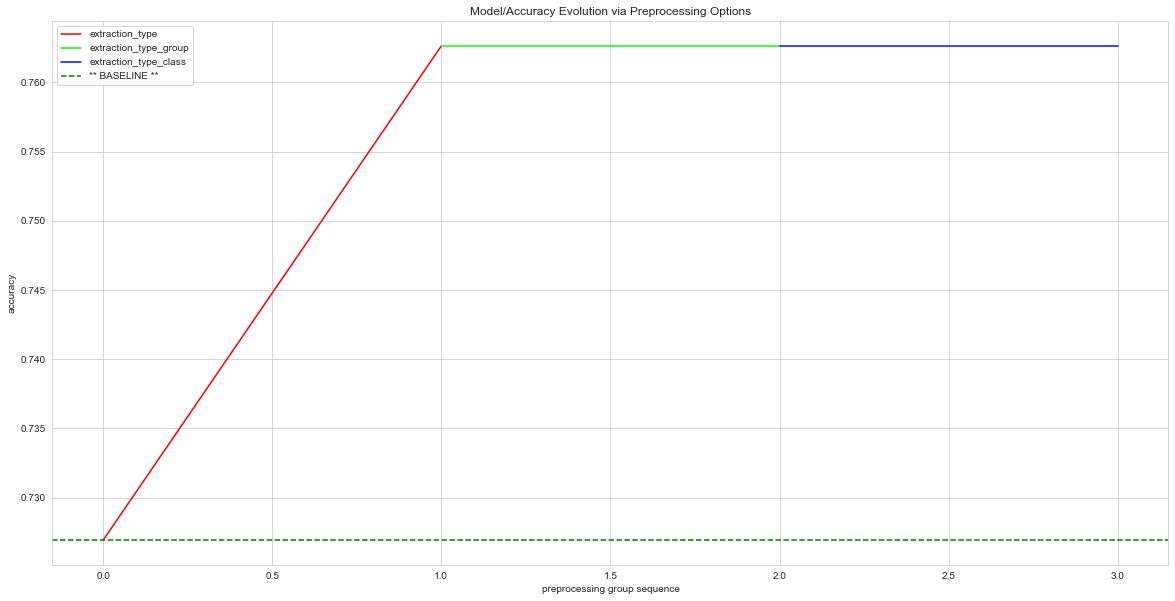

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7cc4290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84b05d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8479890>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c200d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['drop feature: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84a7f90>] to pipeline
strategy "drop feature: amount_tsh" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


strategy appended step ['leave feature as is (do nothing): amount_tsh', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7cc49e0>)] to pipeline
strategy "leave feature as is (do nothing): amount_tsh" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7cc4c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cce0d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" dropped feature 'amount_tsh' after target encoding
strategy transformation of feature 'amount_tsh' to 'amount_tsh_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


strategy appended step ['replace "amount_tsh" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feef7fd6750>] to pipeline
strategy "replace "amount_tsh" outliers with mean" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


strategy appended step ['replace "amount_tsh" outliers with median', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed849ead0>] to pipeline
strategy "replace "amount_tsh" outliers with median" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8952830>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


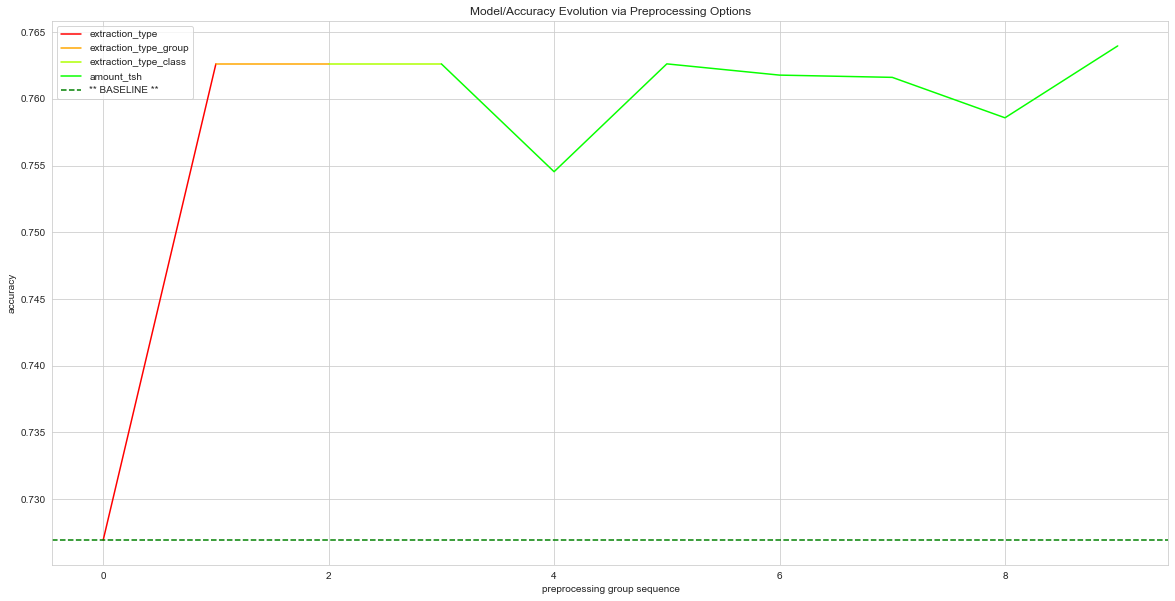

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cc830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd6a8a50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cb2650>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cb2ed0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8932b90>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7ca99d0>] to pipeline
strategy "drop feature: source" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6af050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd6b3b50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


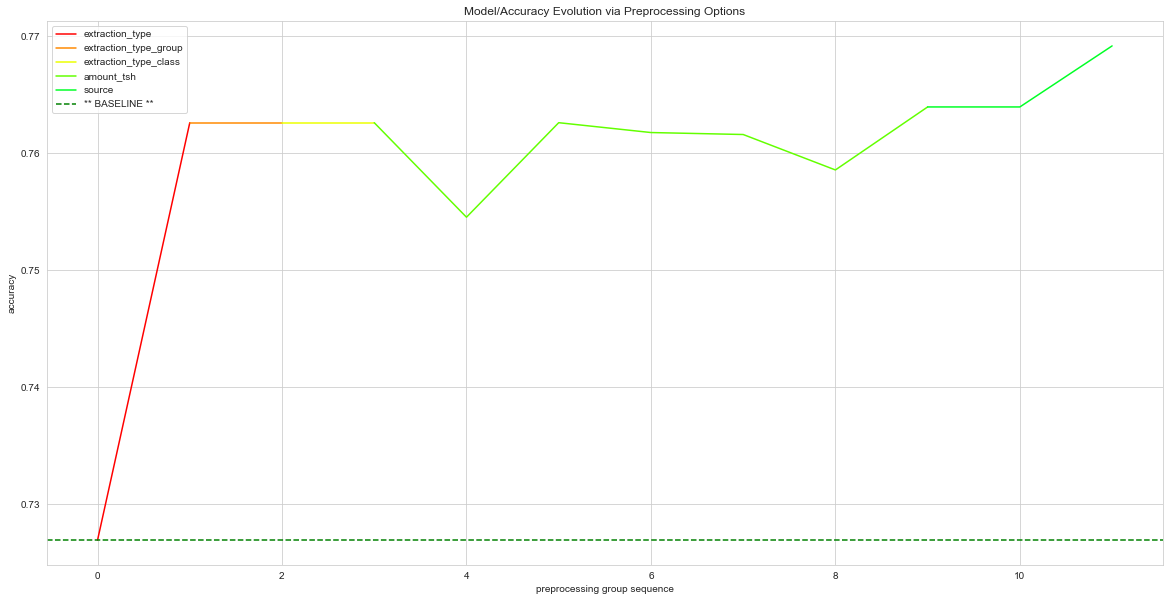

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cc830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cba050>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8024bd0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7ccef50>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8c01290>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed93b30e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cb2390>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cb2190>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


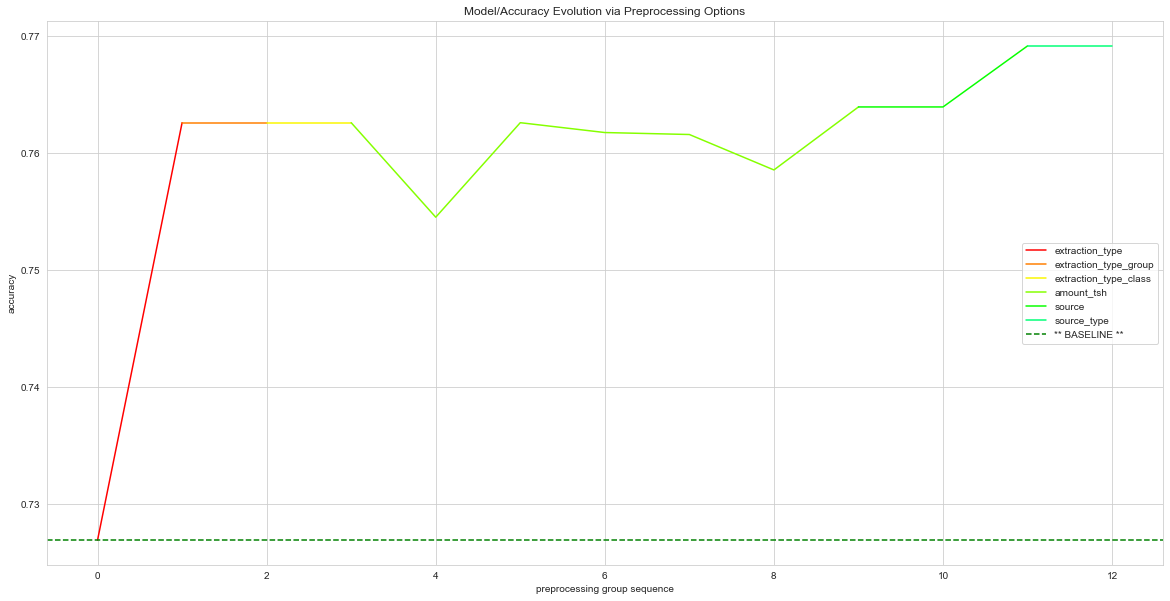

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7ded170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e0da50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7d92710>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8787f90>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed93b3200>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7ded7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e0d610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8772b10>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cc0790>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


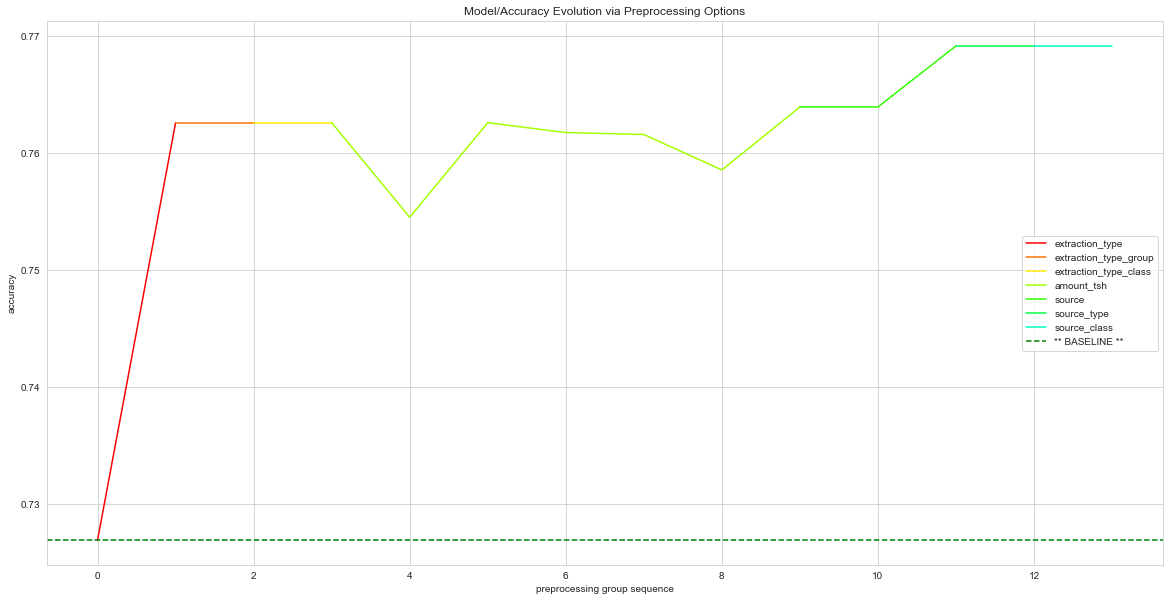

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7ded710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e5b610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd6bf610>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd322e90>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7e19200>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd33a560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e5b190>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7dcd350>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93bb250>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


strategy appended step ['drop feature: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7dcd650>] to pipeline
strategy "drop feature: quantity" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7e61dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd3312d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


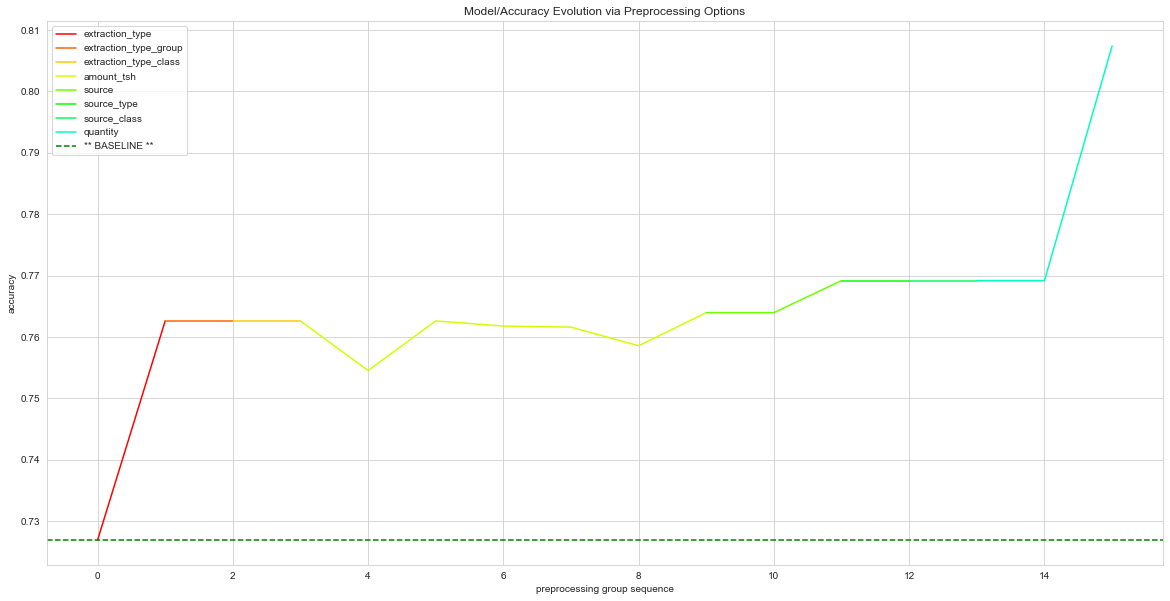

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7ded7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1f4790>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1f4310>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd2fc0d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7ded710>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd627290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd639790>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1f40d0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7bd10>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd627950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd639f50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1f41d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


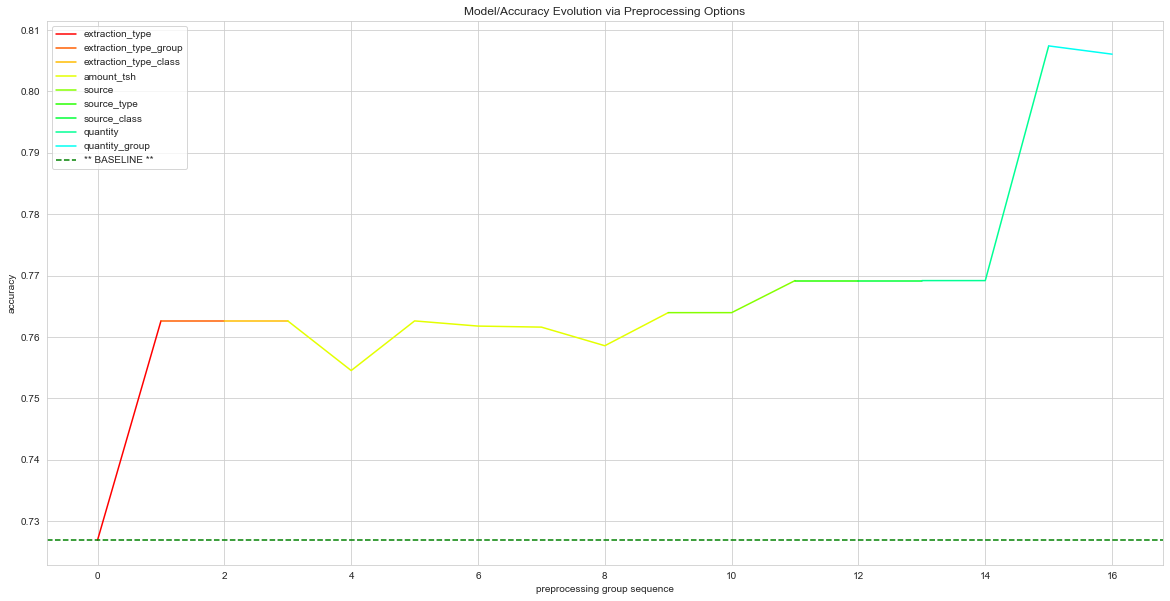

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7cff440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8489b10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7ba90>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd6145d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7cfe8c0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7d01320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed89479d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7dcdfd0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd6148d0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7d017a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8947d10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd614cd0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


strategy appended step ['drop feature: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed89477d0>] to pipeline
strategy "drop feature: water_quality" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7d013b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8787250>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


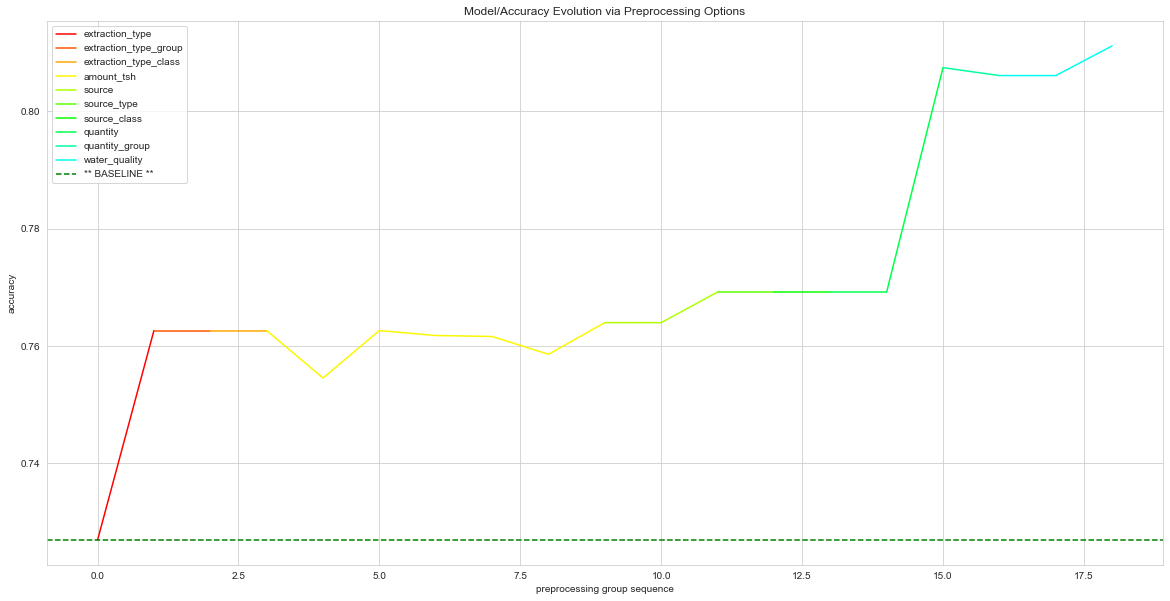

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1bbc9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7b590>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8947250>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8947c10>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb6159e0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7d01ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8489b50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1f9090>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7b8d0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7d01c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeaf9ac10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8489b10>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7cffa70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeaf9a750>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeaf9af10>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


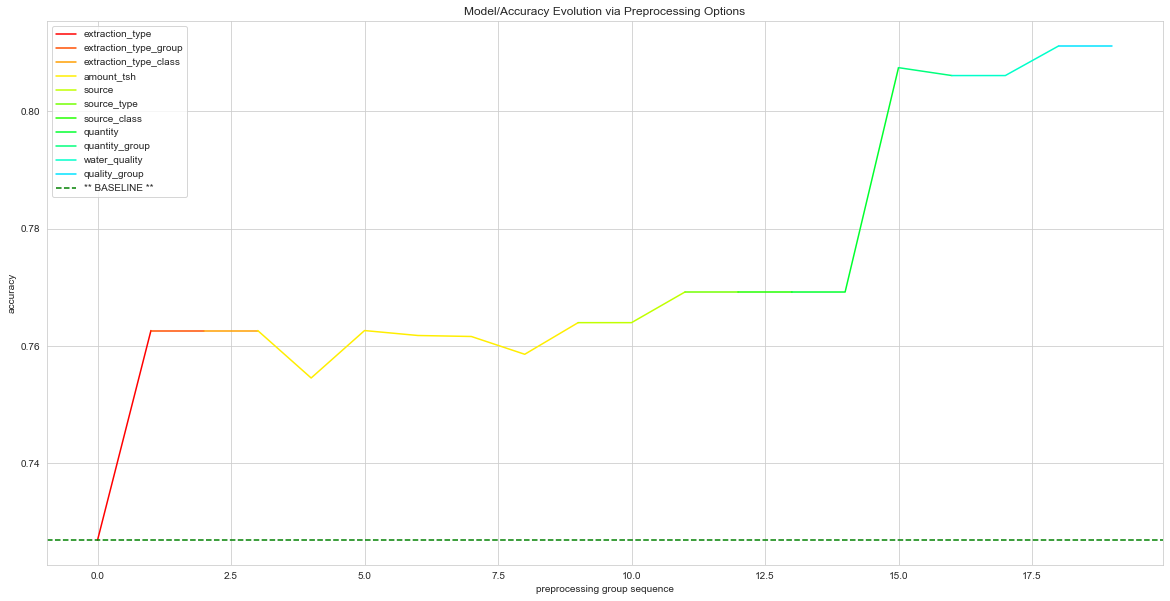

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb6159e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7b090>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd647d10>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7dcdfd0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7cffa70>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7d01ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1e7210>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd2f39d0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd6bf410>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed80124d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeed20cd90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1e2d10>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1bbf560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8489690>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7dcd910>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['drop feature: gps_height', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd6bf790>] to pipeline
strategy "drop feature: gps_height" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8012b90>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: gps_height', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1bbc9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'gps_height' in X match those that were previously fit
added new feature: gps_height_target_encoded
strategy appended step ['drop after target encoding: gps_height', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e32990>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: gps_height" dropped feature 'gps_height' after target encoding
strategy transformation of feature 'gps_height' to 'gps_height_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "gps_height" outliers with mean', FunctionTransformer(func=<function C__replace_outliers__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8012b90>)] to pipeline
strategy "replace "gps_height" outliers with mean" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy appended step ['replace "gps_height" outliers with median', FunctionTransformer(func=<function C__replace_outliers__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed80004d0>)] to pipeline
strategy "replace "gps_height" outliers with median" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy appended step ['replace "gps_height" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8012b90>)] to pipeline
strategy "replace "gps_height" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


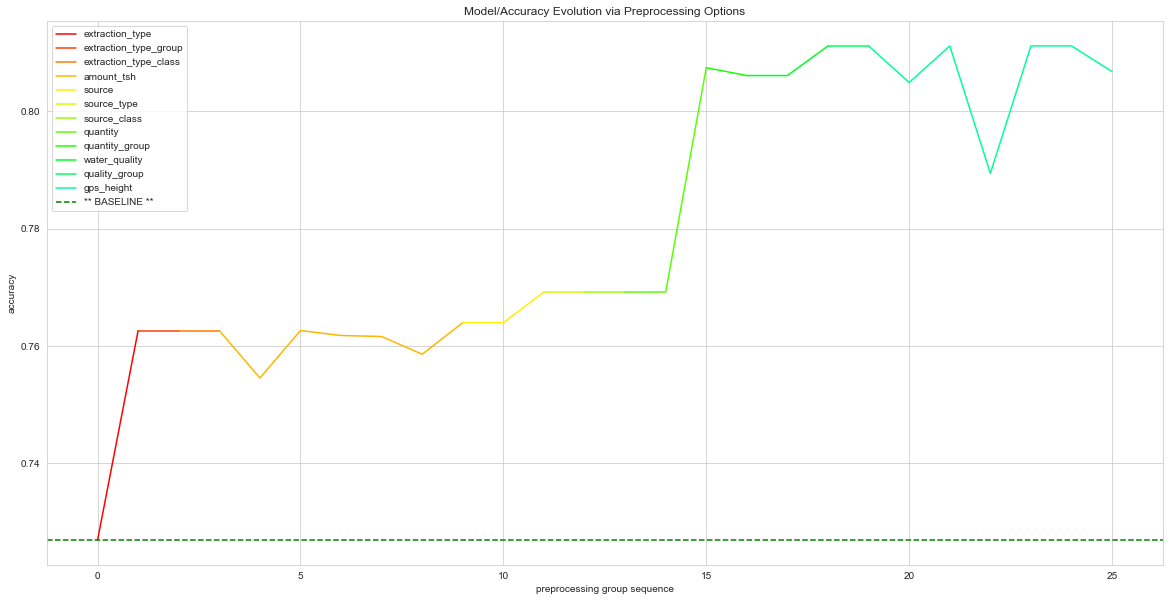

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcddb950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcdee210>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed875e890>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed875e850>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7cfe8c0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcde9290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcdee350>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c5e8d0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed875ea10>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcde9830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcdee150>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed801d050>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcde9710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcdee290>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8bfe3d0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7d01c20>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['drop feature: latitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcdee990>] to pipeline
strategy "drop feature: latitude" transformation is COMPLETE!
strategy appended step ['drop feature: longitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcdee250>] to pipeline
strategy "drop feature: longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcde98c0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcde9c20>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy appended step ['drop feature: latitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8be9710>] to pipeline
strategy "drop feature: latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcde9dd0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcde9b00>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['drop feature: longitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcdeec10>] to pipeline
strategy "drop feature: longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feedcdf9ad0>] to pipeline
strategy "replace values for feature: latitude" transformation is COMPLETE!
strategy appended step ['drop feature: latitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed875a4d0>] to pipeline
strategy "drop feature: latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcde9560>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feedcdf9490>] to pipeline
strategy "replace values for feature: latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcde94d0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['drop feature: longitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcdf9510>] to pipeline
strategy "drop feature: longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feedce03810>] to pipeline
strategy "replace values for feature: latitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


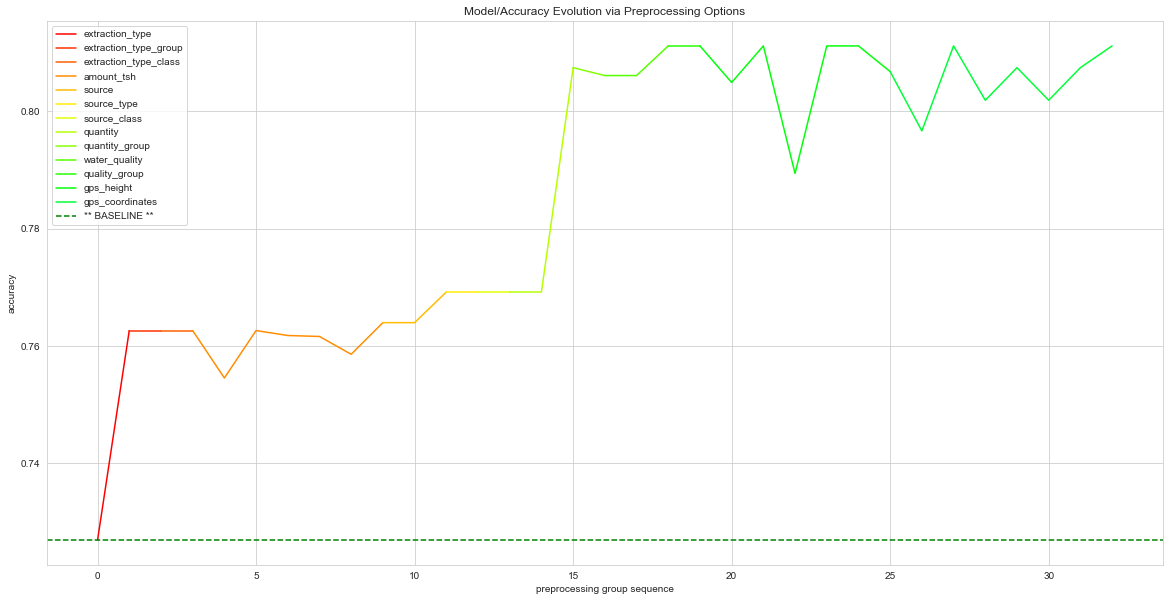

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd139b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcfe47d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd13b950>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd13b850>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedce093b0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd139680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcff28d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd13b8d0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8c15390>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd1395f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcff2410>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcfe49d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bf6b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcff2810>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd13b550>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcfde680>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedce0d320>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed858e0e0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


strategy appended step ['drop feature: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcff2cd0>] to pipeline
strategy "drop feature: waterpoint_type" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed858e5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcff2cd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

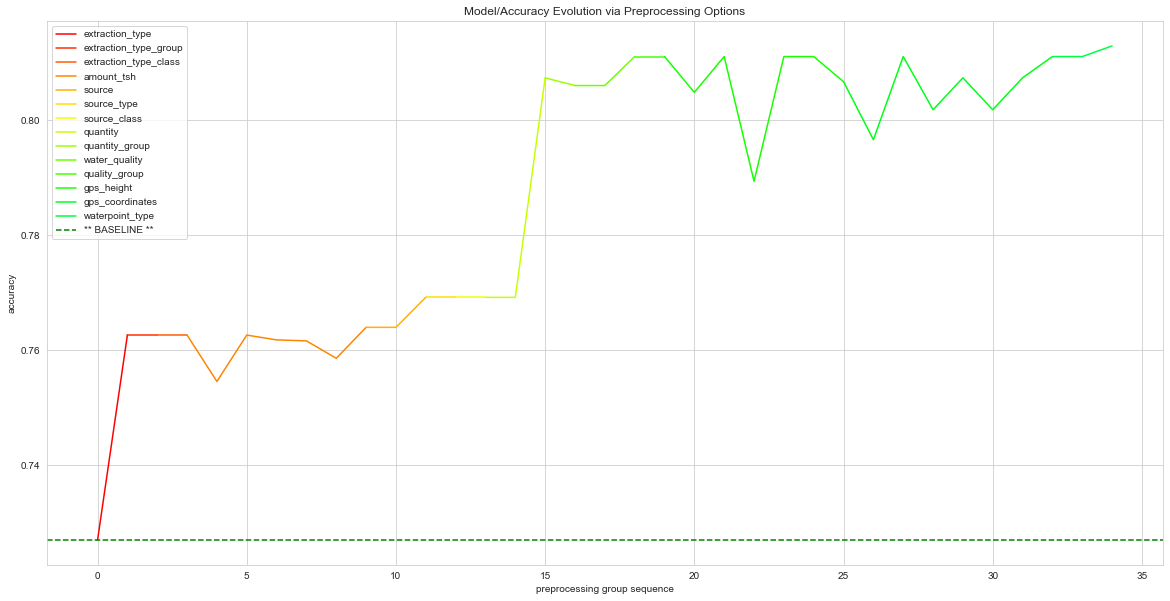

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed85b5b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed85dd290>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd5c5950>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd5c5390>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd5a0b00>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed85e6f50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed85dde90>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed85dd750>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed83297a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed85e6450>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd598a50>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed85e6110>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd5c5590>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd139680>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed85c97a0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed83298c0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed85e6590>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed85e6250>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

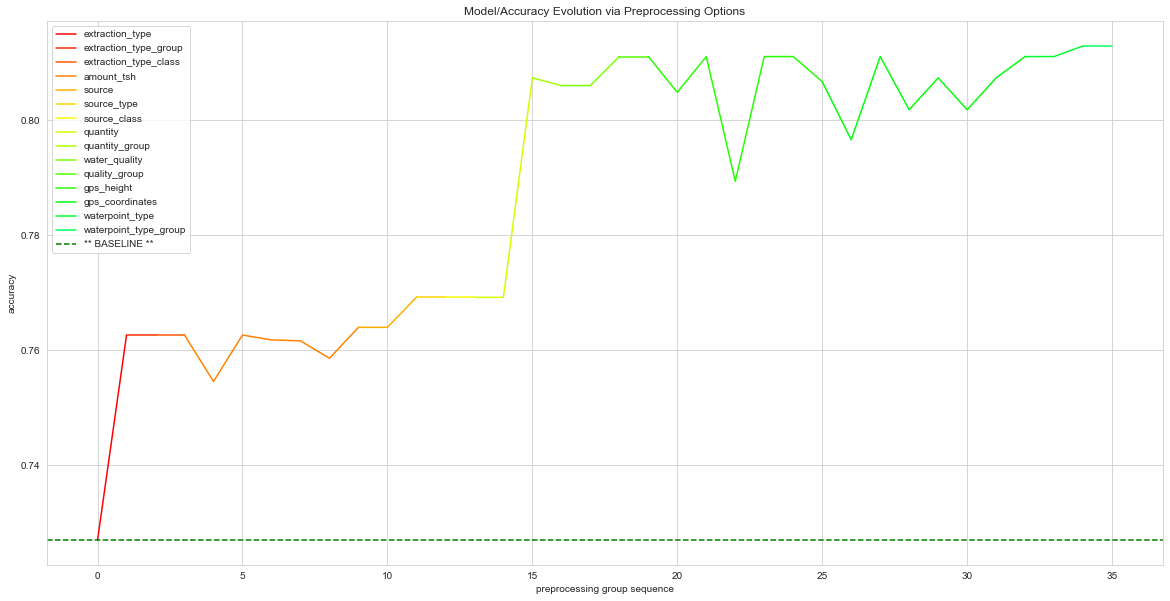

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feede7580e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8705050>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede75c850>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede7349d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feede758050>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed85c9a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8705490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede734690>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede734150>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed871b750>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8705510>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8346b90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8705c10>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329710>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed83297a0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329b90>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8346550>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8705d90>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed83461d0>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329ef0>)] to pipeline
strategy "impute lower-case transform: installer" transformation is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed93bc510>] to pipeline
strategy "replace values for feature: installer" transformation is COMPLETE!
strategy 

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed83299e0>)] to pipeline
strategy "impute lower-case transform: installer" transformation is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed80663d0>] to pipeline
strategy "replace values for feature: installer" transformation is COMPLETE!
strategy 

strategy appended step ['tfidf normalize string-categorical: installer', FunctionTransformer(func=<function C__tfidf_normalize__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329dd0>)] to pipeline


strategy "tfidf normalize string-categorical: installer" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: installer', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed83295f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'installer' in X match those that were previously fit
added new feature: installer_target_encoded
strategy appended step ['drop after target encoding: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84b4e90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: installer" dropped feature 'installer' after target encoding
strategy transfo

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 28 categories of 'installer' occur in X (out of 521 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'installer' has 31 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: installer_target_encoded


strategy appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329320>)] to pipeline
strategy "impute lower-case transform: installer" transformation is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feede3dfb50>] to pipeline
strategy "replace values for feature: installer" transformation is COMPLETE!
strategy 

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

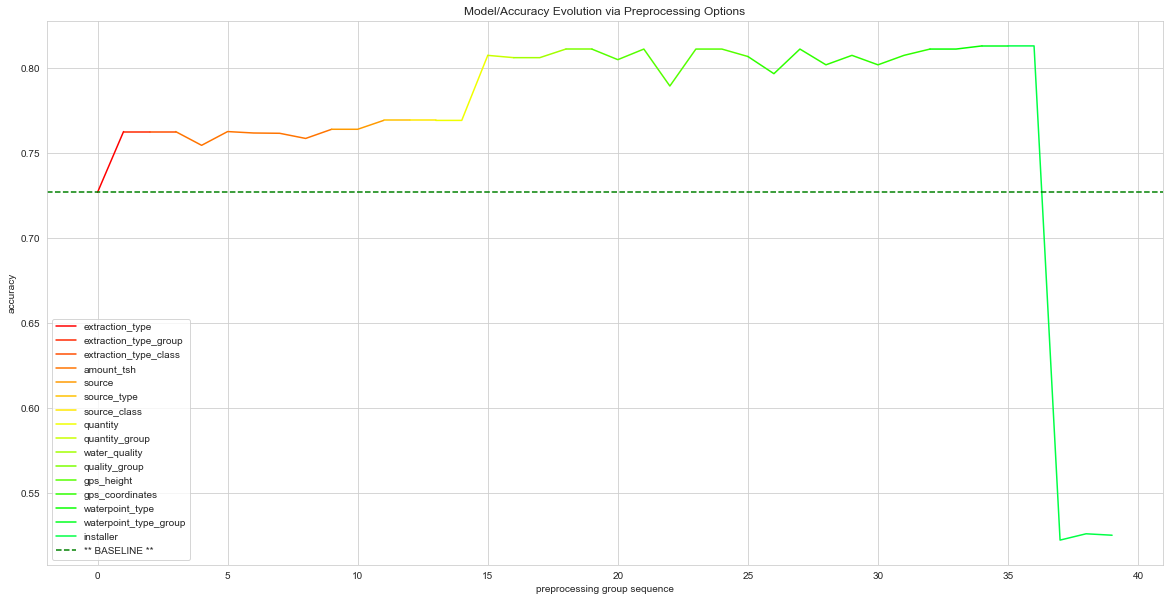

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd5a3b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848e610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848c810>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848fed0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcfded40>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed801e5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848ea10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93b68d0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93874d0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed801ec20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848e110>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8497510>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed801ecb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8484350>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848e1d0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcdfe8c0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd5a3b00>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed801eb00>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed801ea70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8484650>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848ec10>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93a7d50>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['drop feature: population', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84840d0>] to pipeline
strategy "drop feature: population" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['leave feature as is (do nothing): population', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed801eb90>)] to pipeline
strategy "leave feature as is (do nothing): population" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: population', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed801edd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'population' in X match those that were previously fit
added new feature: population_target_encoded
strategy appended step ['drop after target encoding: population', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8047fd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: population" dropped feature 'population' after target encoding
strategy transformation of feature 'population' to 'population_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed847b3d0>] to pipeline
strategy "replace "population" outliers with mean" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed8055e10>] to pipeline
strategy "replace "population" outliers with mean" transformation is COMPLETE!
strategy appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed8044450>] to pipeline
strategy "replace "population" outliers with mean" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "population" outliers with median', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed84788d0>] to pipeline
strategy "replace "population" outliers with median" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed801e710>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

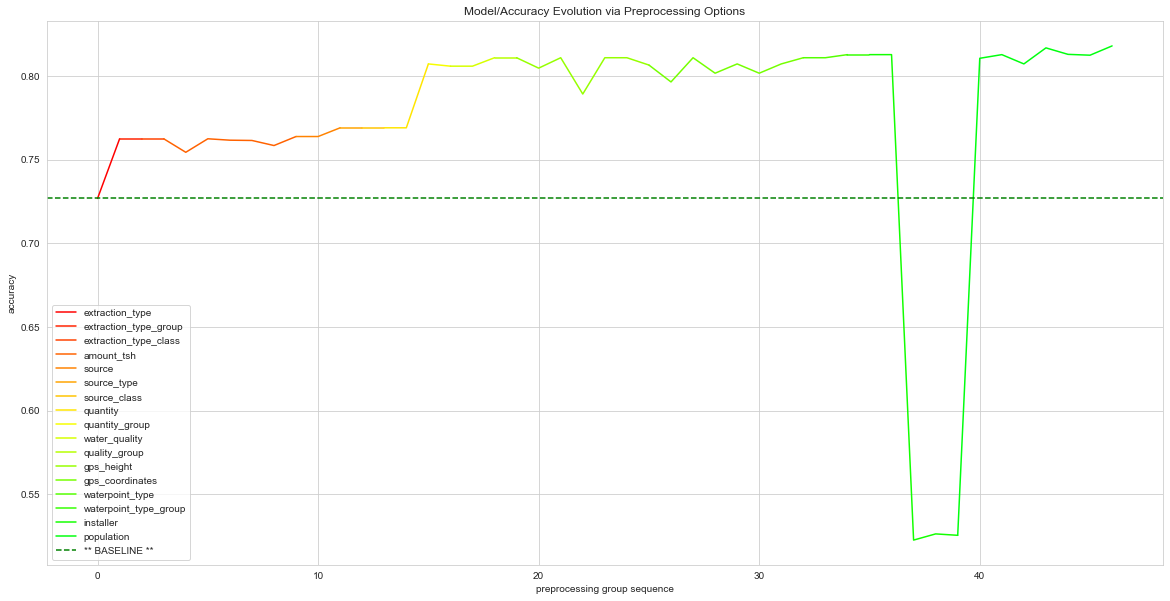

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfab90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848a910>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84b2ed0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848a650>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7deddd0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8045410>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848ae90>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84b2790>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8051050>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84a8fd0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfaa70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed847ee50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed849ab10>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7ded050>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7deda70>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfad40>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfae60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed847e790>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed80692d0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848a190>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa0e0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84a85d0>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8040290>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!
strategy appended step ['drop feature: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed847e690>] to pipeline
strategy "drop feature: district_code" transformation is COMPLETE!
strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed847e0d0>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!
strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8487090>] to pipeline
strategy "drop feature: ward"

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfaf80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848ecd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84873d0>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed849cad0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8482450>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8043d10>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8487750>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8497f50>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!
strategy appended step ['drop feature: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8042c50>] to pipeline
strategy "drop feature: district_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: lga', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa050>)] to pipeline
** TargetEncoderLOOTransformer TRAN

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed806dd50>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8493150>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!
strategy appended step ['drop feature: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed847bcd0>] to pipeline
strategy "drop feature: district_code" transformation is COMPLETE!
strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8497a50>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==T

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cc3b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499150>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cc0e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cd5c50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cccb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8493ed0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bc1a10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cd5690>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cc950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7de6610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeaf9af50>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfaef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7de6290>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bc1d90>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6ccc20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee0224110>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8482310>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeaf9ae10>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cc0e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7de8a50>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed938b050>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93b4950>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bc15d0>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!
strategy appended step ['drop feature: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd269710>] to pipeline
strategy "drop feature: district_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: lga', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed85a3290>)] to pipeline
** TargetEncoderLOOTransformer TRAN

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd272290>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93b4d50>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6ccb90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed847c410>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1c9ad0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1bcd90>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1be3560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeddb84850>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1bc910>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1be35f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeddb0f590>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1be3050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede0d4090>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1be35f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede02e250>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cc830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd6149d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cc290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8489c90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cc440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede412410>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cce60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e6d0d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7d81850>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfab00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84b0ad0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cc830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8b72710>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93c0750>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd6cc9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1bc650>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7ded290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd753250>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7dedcb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede6f6710>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

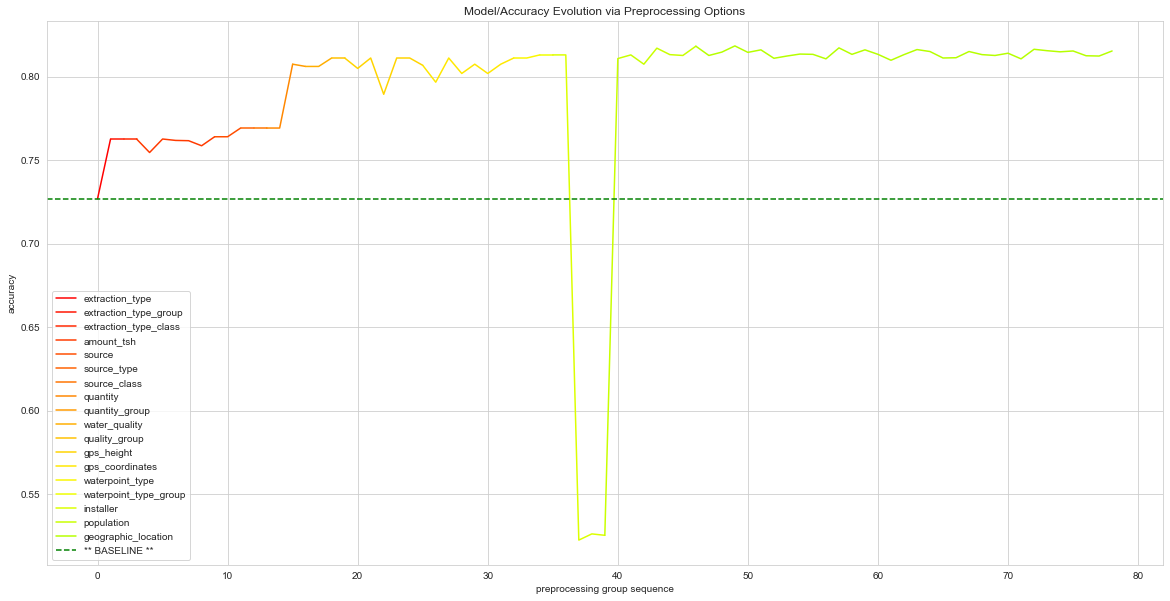

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8b7f440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ba4a50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd6e40d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd6dff50>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa5f0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bab0e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a4de10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed848af10>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a36850>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bab680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a55950>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a55d10>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bab5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8477f90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a55a50>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8a798c0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8a4ee60>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bab7a0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bab290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a6cad0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a5f410>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8042310>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7ded4d0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a559d0>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8babb00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8b8f210>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a73350>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

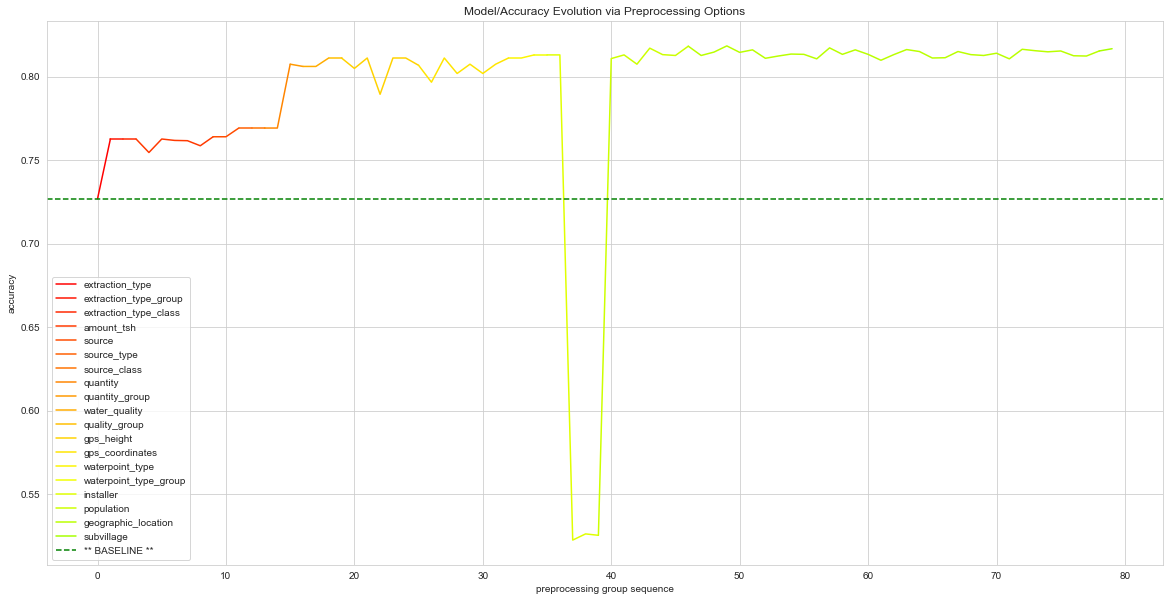

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8babd40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a7b0d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8edb090>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ef0850>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8ed63b0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed83299e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ba4e90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ea6ad0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a7b1d0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ba4a50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a7bad0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ecd890>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ecd6d0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8ed6c20>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8e44b90>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed83298c0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f09090>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ecd710>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ba4390>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329710>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a7bdd0>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a45b10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ba48d0>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f09210>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f09b10>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: scheme_management', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bab830>)] to pipeline
strategy "impute lower-case transform: scheme_management" transformation is COMPLETE!
strategy "replace values for feature: scheme_management" replacement_rules:
{
    "scheme_management": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_management', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed8a8b050>] to pipeline
strategy "replace values for feature: scheme_management" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_management', Funct

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c73050>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329290>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed7c47bd0>] to pipeline
strategy "replace values for feature: scheme_name" transformation is COMPLETE!
strategy "replace valu

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd31f7d0>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329c20>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed7dcc2d0>] to pipeline
strategy "replace values for feature: scheme_name" transformation is COMPLETE!
strategy "replace valu

strategy appended step ['tfidf normalize string-categorical: scheme_name', FunctionTransformer(func=<function C__tfidf_normalize__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329950>)] to pipeline


strategy "tfidf normalize string-categorical: scheme_name" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_name', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'scheme_name' in X match those that were previously fit
added new feature: scheme_name_target_encoded
strategy appended step ['drop after target encoding: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c18e90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_name" dropped feature 'scheme_name' after target encoding
st

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 22 categories of 'scheme_name' occur in X (out of 1085 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'scheme_name' has 35 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: scheme_name_target_encoded


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8efba10>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329b00>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed8ee8a10>] to pipeline
strategy "replace values for feature: scheme_name" transformation is COMPLETE!
strategy "replace valu

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: scheme_management', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8ed60e0>)] to pipeline
strategy "impute lower-case transform: scheme_management" transformation is COMPLETE!
strategy "replace values for feature: scheme_management" replacement_rules:
{
    "scheme_management": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_management', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed8947290>] to pipeline
strategy "replace values for feature: scheme_management" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_management', Funct

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: scheme_management', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329680>)] to pipeline
strategy "impute lower-case transform: scheme_management" transformation is COMPLETE!
strategy "replace values for feature: scheme_management" replacement_rules:
{
    "scheme_management": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_management', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feeeb6151d0>] to pipeline
strategy "replace values for feature: scheme_management" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_management', Funct

strategy appended step ['tfidf normalize string-categorical: scheme_name', FunctionTransformer(func=<function C__tfidf_normalize__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329cb0>)] to pipeline


strategy "tfidf normalize string-categorical: scheme_name" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_name', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'scheme_name' in X match those that were previously fit
added new feature: scheme_name_target_encoded
strategy appended step ['drop after target encoding: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f09a10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_name" dropped feature 'scheme_name' after target encoding
st

strategy "impute lower-case transform: scheme_management" transformation is COMPLETE!
strategy "replace values for feature: scheme_management" replacement_rules:
{
    "scheme_management": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_management', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed85b44d0>] to pipeline
strategy "replace values for feature: scheme_management" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8ed6950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** T

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

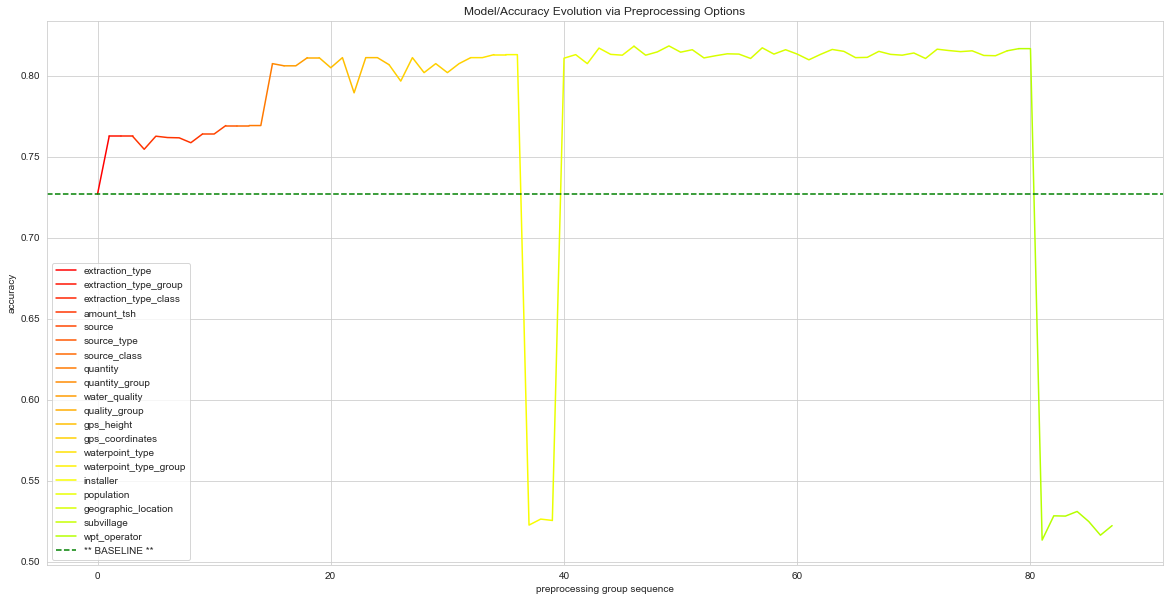

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7e67290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8b8fa50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7ffe150>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7ff5510>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8ed6a70>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4a440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1be7750>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8493410>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84a7150>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4aa70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1be7a50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8493250>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4a830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1be7e90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8b8f490>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c74710>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8329290>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4a9e0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4ab00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1be7c90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84a7590>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8b8ff10>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7e67a70>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1be7710>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4a8c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd07ab90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1be7690>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeb5f5c10>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeff9a1d50>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeb5f55d0>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['drop feature: construction_year', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeb5f5990>] to pipeline
strategy "drop feature: construction_year" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeb5f55d0>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4aef0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ["convert (from string date format '%Y-%m-%d') to datetime type: date_recorded", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4aef0>)] to pipeline
strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" transformation is COMPLETE!
strategy appended step ['replace 0 with date_recorded value: construction_year', FunctionTransformer(func=<function C__replace_0_construction_year_with_date_recorded__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4af80>)] to pipeline
strategy "replace 0 with date_recorded value: construction_year" transformation is COMPLETE!
strategy appended step ["convert (from string date format '%Y') to datetime type: construction_year", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd34b050>)] to pipeline
strategy "conve

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1be7a90>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: construction_year', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4aef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'construction_year' in X match those that were previously fit
added new feature: construction_year_target_encoded
strategy appended step ['drop after target encoding: construction_year', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8487d50>] to pipeline
strategy "

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a5f750>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['replace "construction_year" outliers with mean', FunctionTransformer(func=<function C__replace_outliers__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4ab90>)] to pipeline
strategy "replace "construction_year" outliers with mean" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeb5f55d0>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['replace "construction_year" outliers with median', FunctionTransformer(func=<function C__replace_outliers__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4af80>)] to pipeline
strategy "replace "construction_year" outliers with median" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed894d490>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['replace "construction_year" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c4af80>)] to pipeline
strategy "replace "construction_year" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ["convert (from string date format '%Y-%m-%d') to datetime type: date_recorded", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c747a0>)] to pipeline
strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" transformation is COMPLETE!
strategy appended step ['replace 0 with date_recorded value: construction_year', FunctionTransformer(func=<function C__replace_0_construction_year_with_date_recorded__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd315320>)] to pipeline
strategy "replace 0 with date_recorded value: construction_year" transformation is COMPLETE!
strategy appended step ["convert (from string date format '%Y') to datetime type: construction_year", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd3154d0>)] to pipeline
strategy "conve

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

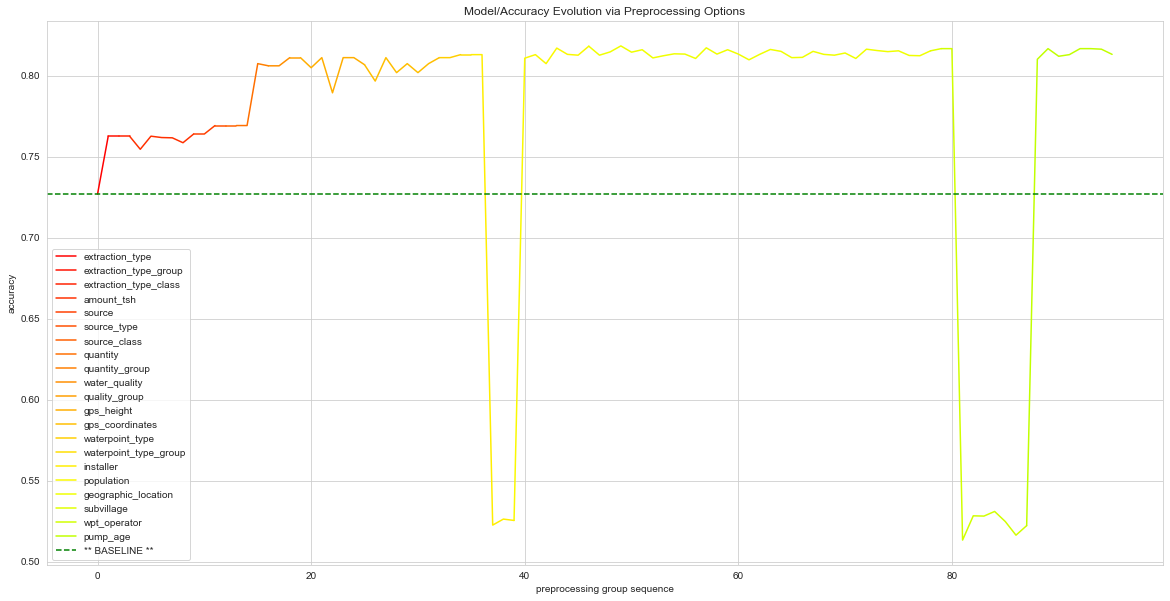

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8a517a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8b8f590>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8b8f5d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7ffe450>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd315710>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8a5d5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069790>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a58c10>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd07ab50>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8a5dc20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069690>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e43ed0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8a5dd40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069f50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bc1b10>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd3150e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8ed6a70>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8a5db00>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8a5d680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcc1cf50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bc19d0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069d50>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd165c20>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd0690d0>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8a5df80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcc1c610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcc1c850>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8e4c890>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd054050>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8e4c0d0>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8a5d8c0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069310>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8c0f560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd084790>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" dropped feature 'payment_type' after target encoding
strategy transformation of feature 'payment_type' to 'payment_type_target_encoded' 

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

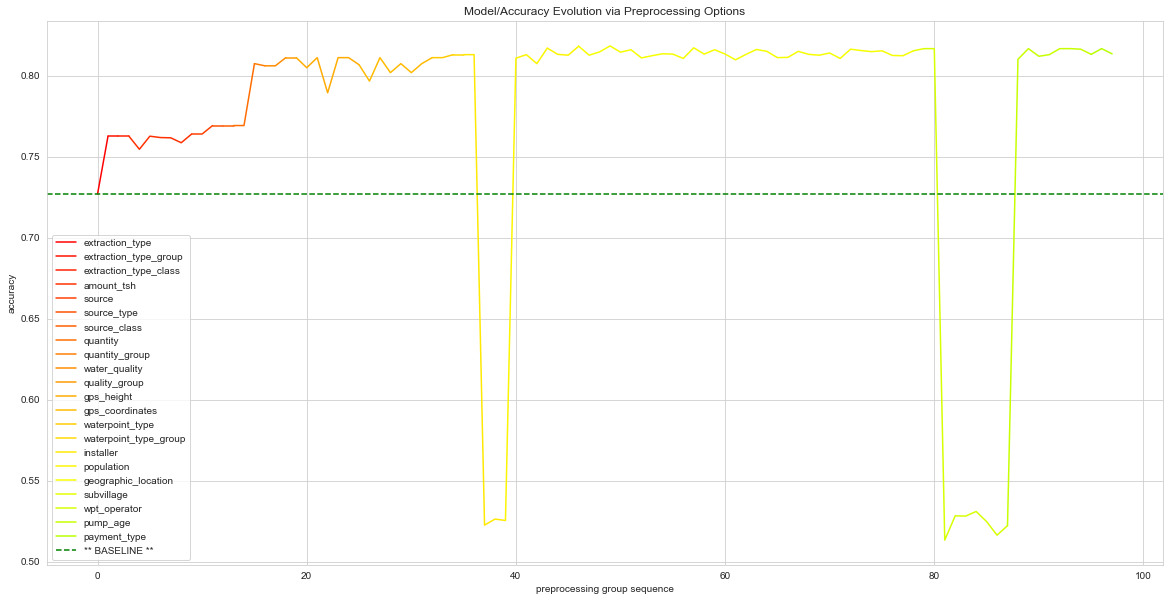

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed93a7710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd32e650>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8e4c890>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069150>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedca640e0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcf0a200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8586b50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8024850>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069a50>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcf0a7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8586350>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069290>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcf0a4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8586ad0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84b0610>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8a5d9e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed93a7680>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcf0a680>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcf0a710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed85861d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8586210>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8789690>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8c08dd0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a57250>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcf0acb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcc1c890>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd054710>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069110>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cb7190>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8e95950>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcf0aa70>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed85866d0>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8586390>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

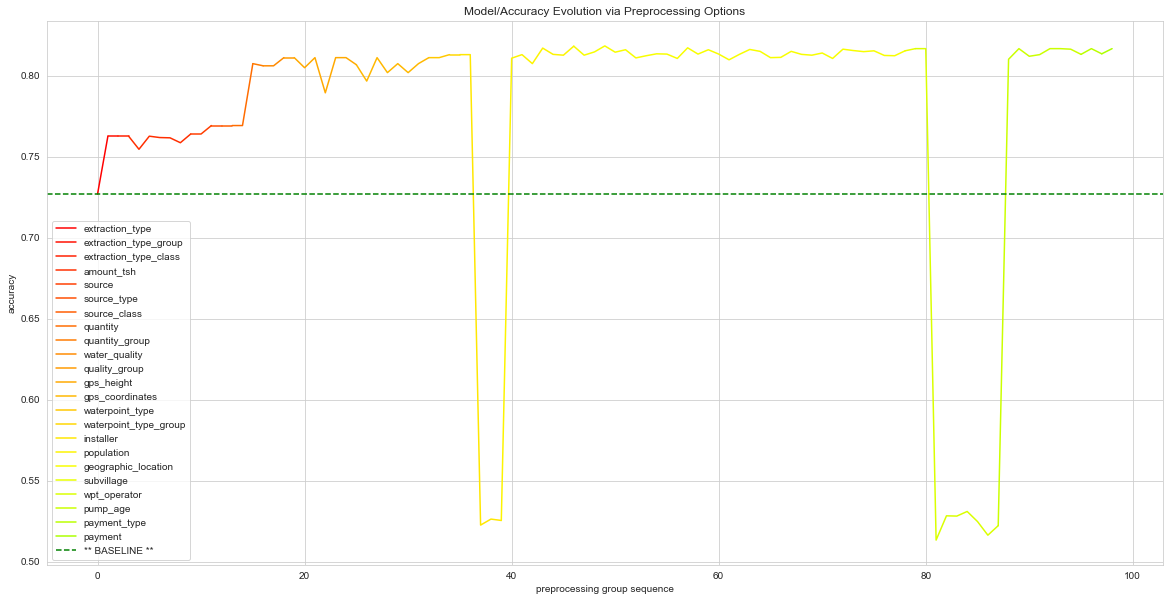

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcddd830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd316c50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069150>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069a50>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed80689e0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed848d7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd316610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed859e590>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd084c10>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed848ddd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd316b90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed859e5d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed848d9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcc1c490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd069490>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd23e9e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd23ec20>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed848dd40>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed848dcb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8481c90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8bdd950>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd5a4a10>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed848db00>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cb7b50>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed848db90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8586510>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cfe390>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8bdd290>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cfe2d0>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8481390>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed848dc20>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8773350>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8bdd510>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8bdd050>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "num_private" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed8bdd050>] to pipeline
strategy "replace "num_private" outliers with mean" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "num_private" outliers with median', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feedd316e10>] to pipeline
strategy "replace "num_private" outliers with median" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "num_private" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcddd950>)] to pipeline
strategy "replace "num_private" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

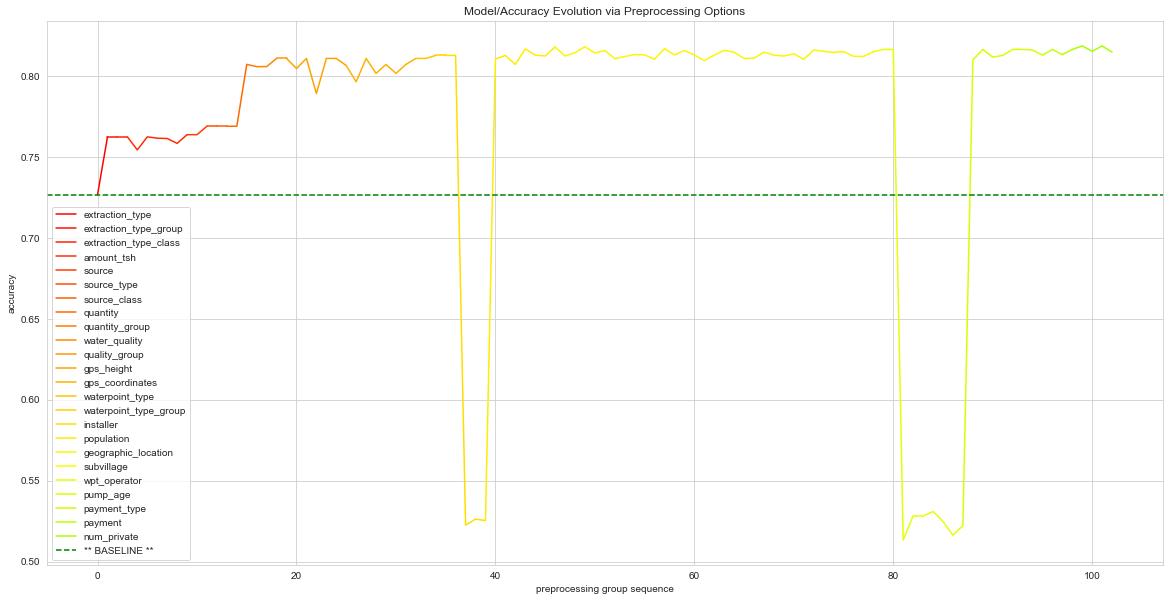

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed848d320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c18890>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcfbe110>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcfbe590>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd23e7a0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8068e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c18b50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e43850>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1be7d50>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8068050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed894d750>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c18d50>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8068c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed894ded0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c18a90>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed84b65f0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8497830>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8068560>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8068b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8be9f50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed894dd50>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8be99d0>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed848d290>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed894da50>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8068830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeeb5f5b50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7ff59d0>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed894d490>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcfbec50>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7ff57d0>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed80680e0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed894d050>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c18b10>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed894d0d0>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8be9410>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

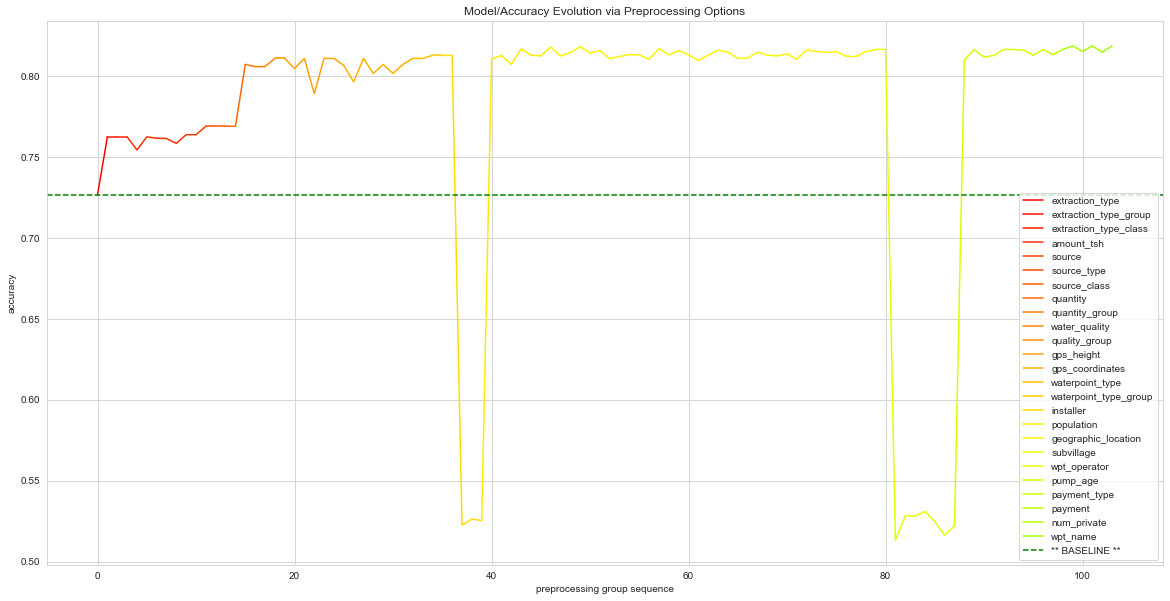

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcfb8dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cd5090>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1be7310>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcdf2d90>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8bfa4d0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8068f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd5b3d90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd084990>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed85764d0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60b4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd5b3d50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e43750>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60b5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd5b3b90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cd52d0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcfb8ef0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeafa1e60>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60b170>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60b290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bb9e50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd5b3250>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed80624d0>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcf0aa70>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8576ed0>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60b950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499ad0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd5b3410>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bb9890>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8062ed0>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bb98d0>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60ba70>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd5b3f90>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bb9350>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bb9b10>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bb9c50>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499a10>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: basin', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeafa1ef0>)] to pipeline
strategy "impute lower-case transform: basin" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: basin', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60bdd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'basin' in X match those that were previously fit
added new feature: basin_target_encoded
strategy appended step ['drop after target encoding: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd613890>] to pipeline


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

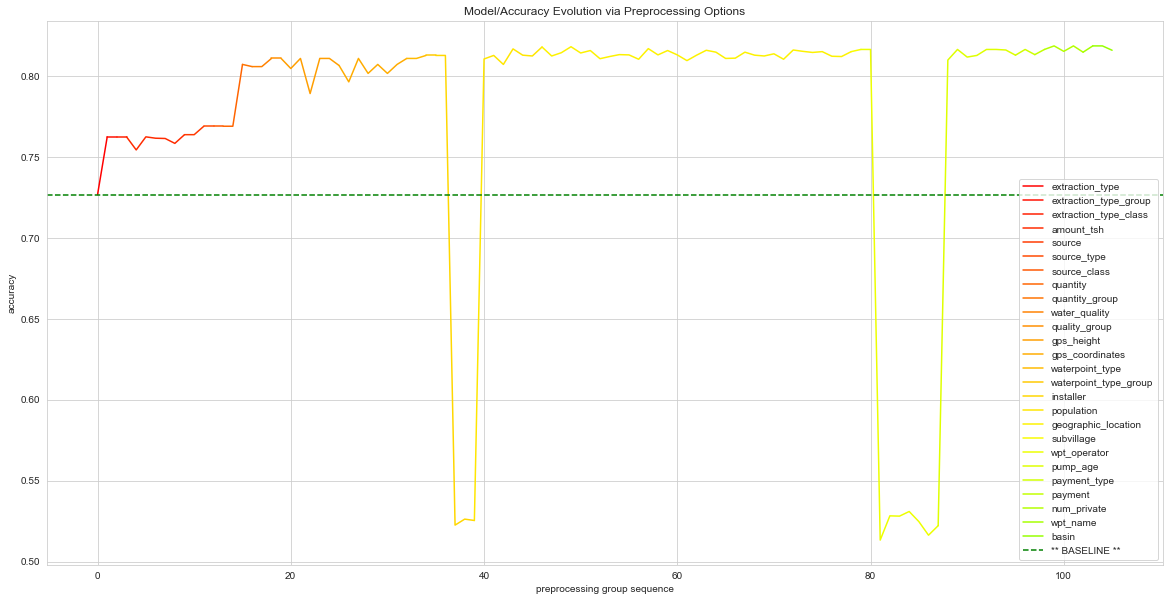

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60bb00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8576650>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8478c90>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8478b90>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1bbf4d0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed89595f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede403310>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499310>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84b5890>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8959b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede403710>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84781d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8959cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede403e50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499950>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd337d40>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb61bc20>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8959680>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8959a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede403c50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede403d10>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede403490>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd337cb0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd613e50>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed89598c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8066310>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ecd710>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede403f50>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede403750>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ecd8d0>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8959d40>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ecd890>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ecdd90>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede403ad0>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede403c10>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feede403110>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ecdbd0>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "replace values for feature: public_meeting" replacement_rules:
{
    "public_meeting": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": false
        }
    ]
}
strategy appended step ['replace values for feature: public_meeting', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed8066150>] to pipeline
strategy "replace values for feature: public_meeting" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

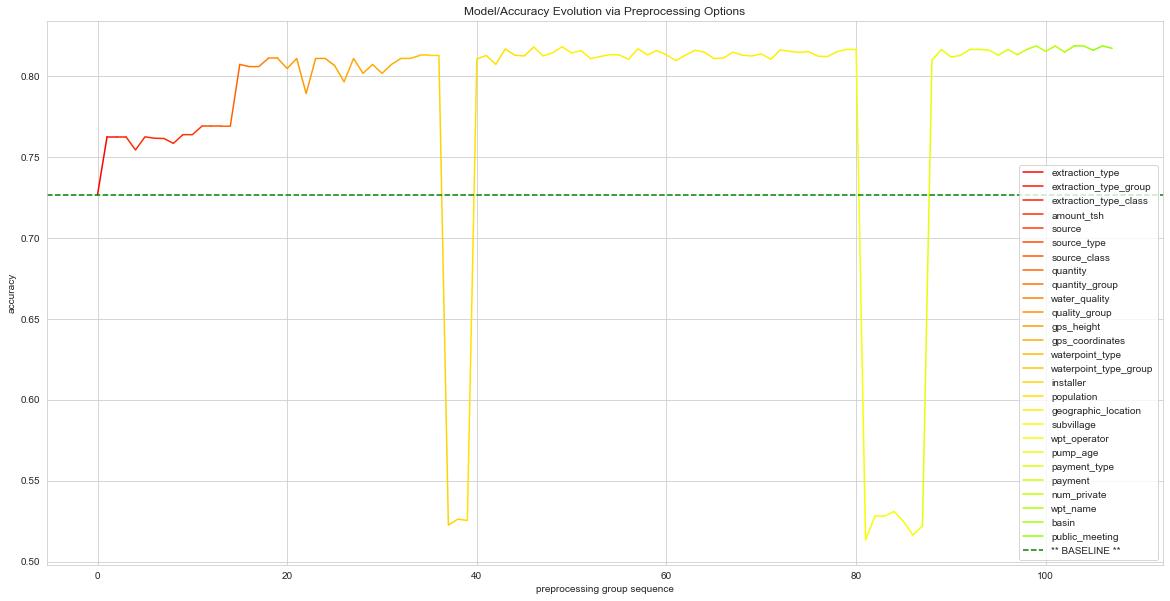

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed9393560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ecd790>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed939a210>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cb5090>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcdd63b0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd14f7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd1608d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed939a310>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed939d890>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd14fd40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd160510>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed939d610>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd14fc20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd160490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93a9710>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcf6b680>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedcdd65f0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd14fe60>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd14f8c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93a4610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93a4f50>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cba190>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd14fb90>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd160e10>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd14ff80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd17d210>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd160850>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd160b10>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feef1bc16d0>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93a4f90>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd14fcb0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8ecd6d0>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd160cd0>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93a4a10>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd17dcd0>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd160d50>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd17d050>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd17d3d0>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

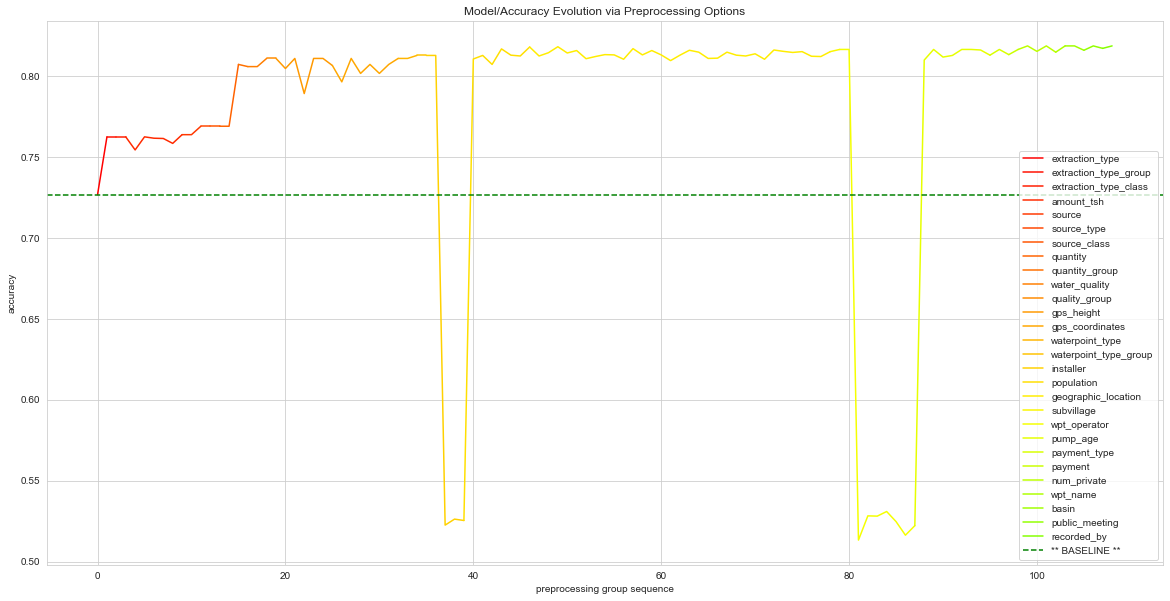

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed80724d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a51090>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed93a9590>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a684d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed9393560>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c68440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7d950>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a51690>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a51590>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c689e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7df90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a516d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c68830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7dc10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c7b1d0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8c04290>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd14f9e0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c688c0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c684d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7d310>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c7b0d0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd6bfc10>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8057f80>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7d7d0>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c68c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e63a90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7df10>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7dd50>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c73450>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7d790>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c68cb0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7d0d0>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7dc50>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7dd90>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e63c10>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7dfd0>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e7d5d0>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e634d0>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


strategy appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e63b50>] to pipeline
strategy "drop feature: permit" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "replace values for feature: permit" replacement_rules:
{
    "permit": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": false
        }
    ]
}
strategy appended step ['replace values for feature: permit', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed7e63090>] to pipeline
strategy "replace values for feature: permit" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

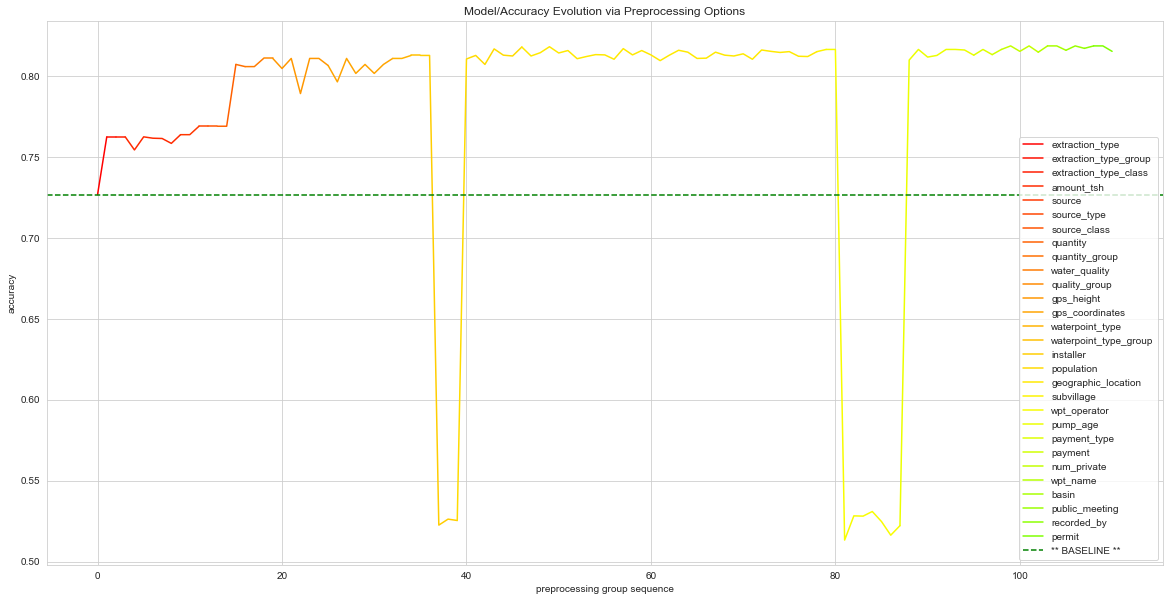

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c688c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f17950>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8a51290>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f17e10>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feedd079170>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f3ab00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8728150>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8728390>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8715f50>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f3acb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f324d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8728250>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f0be60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f20bd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f20210>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f0bdd0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f0bc20>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f0bb00>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f0b830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd05ef50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f20d50>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f20fd0>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f0b710>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f20090>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f0bf80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd05e310>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f20a10>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f20150>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f20110>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f20950>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f0b7a0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd05e050>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd05ec50>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f20050>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd05e550>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd05e8d0>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd05e850>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd05e910>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


strategy appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd05ed90>] to pipeline
strategy "drop feature: permit" transformation is COMPLETE!


strategy appended step ['drop feature: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd05e810>] to pipeline
strategy "drop feature: management" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f0bb90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd065bd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" dropped feature 'management' after target encoding
strategy transformation of feature 'management' to 'management_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

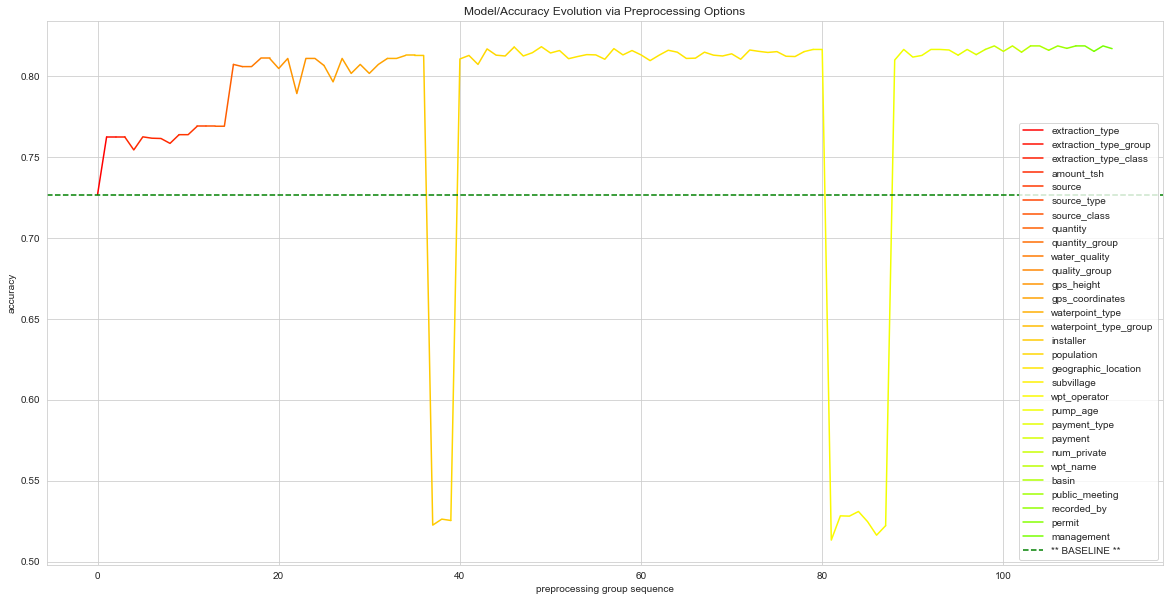

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1bbf710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcfcd4d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b23fd0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcfd8850>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1bbf7a0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1bf67a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cba9d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcfd8250>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b23810>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1bf6830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cba590>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b23e90>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60b4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cbab10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcfd8550>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7e3ff80>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1be67a0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60b200>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60b320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cbad90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cbad50>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cba890>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feef1bf65f0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cba810>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60b830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499510>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cba290>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cbaf10>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcfd8d90>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cba990>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60b7a0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cba350>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cba950>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cba690>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84995d0>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cbac10>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499810>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499b50>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


strategy appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499a90>] to pipeline
strategy "drop feature: permit" transformation is COMPLETE!


strategy appended step ['drop feature: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499e10>] to pipeline
strategy "drop feature: management" transformation is COMPLETE!


strategy appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499d50>] to pipeline
strategy "drop feature: management_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

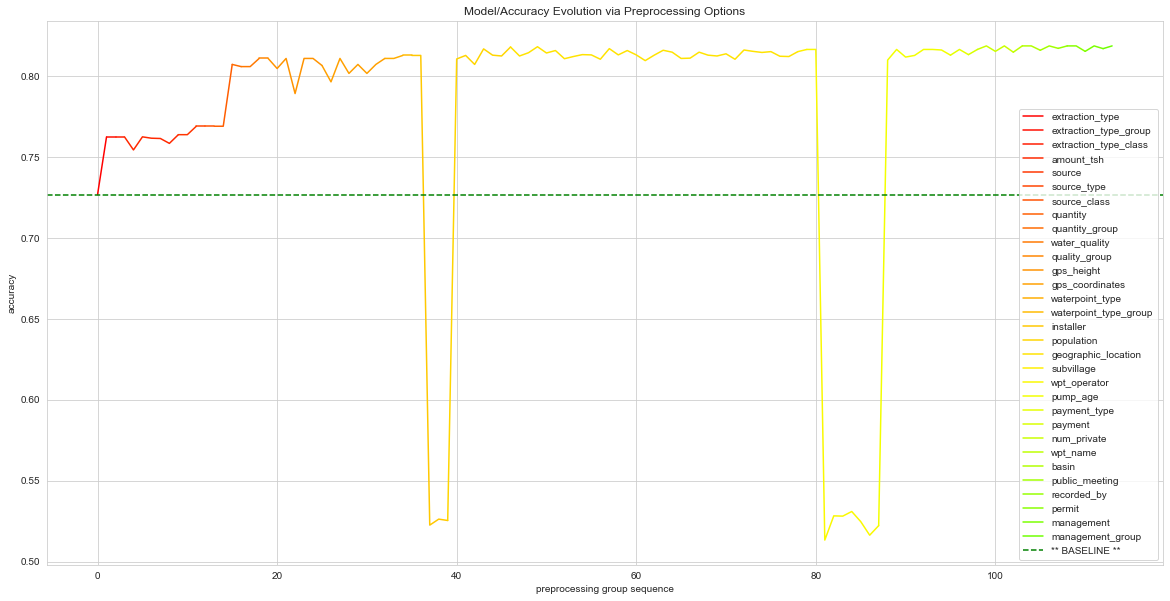

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c44710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8005a10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84995d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8f1e110>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c445f0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c709e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c62b50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed84999d0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7ff5e10>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c70d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c62350>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed8499a90>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c70dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c62b10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7e43b10>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feeeb60b950>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7e599e0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c70a70>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c70f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd332450>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c73610>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c62910>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c68200>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c62d10>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f094d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd332f90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c626d0>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b23990>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b23d90>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c62990>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f09200>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd332dd0>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7c62f10>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd3329d0>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd332e90>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd332a10>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd332b90>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd332390>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


strategy appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd332850>] to pipeline
strategy "drop feature: permit" transformation is COMPLETE!


strategy appended step ['drop feature: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd332510>] to pipeline
strategy "drop feature: management" transformation is COMPLETE!


strategy appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd3320d0>] to pipeline
strategy "drop feature: management_group" transformation is COMPLETE!


strategy appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedd332190>] to pipeline
strategy "drop feature: funder" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c70cb0>)] to pipeline
strategy "impute lower-case transform: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feef1bc1f10>] to pipeline
strategy "replace values for feature: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": "not known",
            "str

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7e59c20>)] to pipeline
strategy "impute lower-case transform: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed8b9cf90>] to pipeline
strategy "replace values for feature: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": "not known",
            "str

strategy appended step ['tfidf normalize string-categorical: funder', FunctionTransformer(func=<function C__tfidf_normalize__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed8f09560>)] to pipeline


strategy "tfidf normalize string-categorical: funder" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c70710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'funder' in X match those that were previously fit
added new feature: funder_target_encoded
strategy appended step ['drop after target encoding: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7de7390>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder" dropped feature 'funder' after target encoding
strategy transformation of feature 'f

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 25 categories of 'funder' occur in X (out of 527 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'funder' has 27 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: funder_target_encoded


strategy appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feed7c70560>)] to pipeline
strategy "impute lower-case transform: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7feed93bee50>] to pipeline
strategy "replace values for feature: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": "not known",
            "str

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

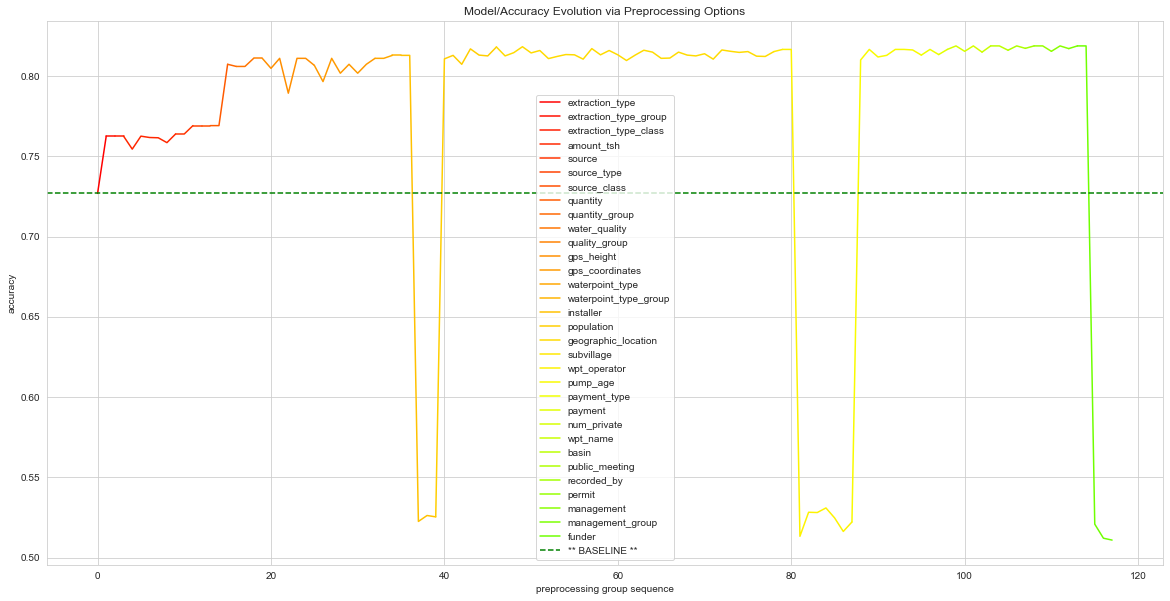

In [25]:
def get_cmap(n, name='hsv'):
    # from https://stackoverflow.com/a/25628397
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

best_options = []
y_acc = []
for feat_group_name in preprocessing_config['feature_groupings']:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']
    
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        best_option, y_acc = find_best_option(feat_group_name, preprocessing_group_name, best_options, y_acc)
        best_options.append(best_option)

        display(HTML("<p><br>"))
        plt.figure(figsize=(20,10))
        x_offset = 0
        cmap = get_cmap(sum(list(map(lambda y_acc_item: len(y_acc_item['acc']), y_acc))))
        for i, y_acc_item in enumerate(y_acc):
            xs = list(range(x_offset, x_offset+len(y_acc_item['acc'])))
            ys = y_acc_item['acc']
            if i > 0: # prepend acc of last item from last list so we don't have any discontinuity in plot
                xs = [x_offset-1] + xs
                ys = [y_acc[i-1]['acc'][-1]] + ys
            plt.plot(xs, ys, c=cmap(i), label=y_acc_item['ppgn'])
            x_offset += len(y_acc_item['acc'])
            
        plt.axhline(y=_accuracy_validation_baseline, linestyle='--', color="red" if best_option[3] < _accuracy_validation_baseline else "green", label='** BASELINE **')
        
        plt.xlabel('preprocessing group/option sequence')
        plt.ylabel('accuracy')
        plt.legend()
        plt.title('Model/Accuracy Evolution via Preprocessing Options')
        plt.show()

        display(HTML("<p><br><br><br><br>"))

## Test Best Preprocessing Options Transformations on `X_train`

In [26]:
scjpnutils.analyze_values(X_train, 'X_train BEFORE preprocessing');

In [27]:
X_train_preprocessed = X_train.copy()

for best_preprocessing_option in best_options:
    composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
        best_preprocessing_option[1], 
        best_preprocessing_option[0],
        pipeline_data_preprocessor
    )
    scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
    X_train_preprocessed = composite_transformer.fit_transform(X_train_preprocessed, y_train_encoded.status_group)
    display(HTML("<p><br><br>"))

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b4a320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fef02b017d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feefd9a9d10>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fef077294d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b4a050>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b3a8c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cce550>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feefd9b0d90>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeed207a50>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b3aef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cceb10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fef02b01350>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b3acb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cce3d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeed227e50>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b4a0e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b4a170>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b3add0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b3af80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3ff10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cce810>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7ccecd0>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b4a3b0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7cceb50>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b25170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region' in X match those that were previously fit
added new feature: region_target_encoded
strategy appended step ['drop after target encoding: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3f9d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feeffb35f90>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feed7ccea50>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!
strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7fef02b01b50>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feedcfd8450>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7feee9b3aa70>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3f790>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3f250>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3f490>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3fad0>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3fe10>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3f850>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3f810>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


strategy appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3fcd0>] to pipeline
strategy "drop feature: permit" transformation is COMPLETE!


strategy appended step ['drop feature: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3f5d0>] to pipeline
strategy "drop feature: management" transformation is COMPLETE!


strategy appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3f910>] to pipeline
strategy "drop feature: management_group" transformation is COMPLETE!


strategy appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7feee9b3f710>] to pipeline
strategy "drop feature: funder" transformation is COMPLETE!


In [ ]:
scjpnutils.analyze_values(X_train_preprocessed, 'X_train AFTER preprocessing');

## Save Transformed Training Data to CSV for Final Model Building

### Save Configuration First

In [ ]:
best_preprocessing_config = {}

for best_preprocessing_option in best_options:
    best_preprocessing_config.update({best_preprocessing_option[0]: best_preprocessing_option[1]})

best_preprocessing_config

{'extraction_type': [['extraction_type',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'extraction_type_group': [['extraction_type_group',
   'C__drop_it__StrategyTransformer']],
 'extraction_type_class': [['extraction_type_class',
   'C__drop_it__StrategyTransformer']],
 'amount_tsh': [['amount_tsh', 'C__replace_0_with_nan__StrategyTransformer']],
 'source': [['source',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'source_type': [['source_type', 'C__drop_it__StrategyTransformer']],
 'source_class': [['source_class', 'C__drop_it__StrategyTransformer']],
 'quantity': [['quantity',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'quantity_group': [['quantity_group', 'C__drop_it__StrategyTransformer']],
 'water_quality': [['water_quality',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'quality_group': [['quality_group', 

## Test Best Preprocessing Options Transformations (using the `Pipeline`) on `X_validation`

In [ ]:
scjpnutils.analyze_values(X_validation, 'X_validation BEFORE preprocessing');

In [ ]:
X_validation_preprocessed = pipeline_data_preprocessor.transform(X_validation)

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

In [ ]:
scjpnutils.analyze_values(X_validation_preprocessed, 'X_validation AFTER preprocessing');

## Test Best Preprocessing Options Transformations (using the `Pipeline`) on `X_unlabeled`

In [ ]:
scjpnutils.analyze_values(X_unlabeled, 'X_unlabeled BEFORE preprocessing');

In [ ]:
X_unlabeled_preprocessed = pipeline_data_preprocessor.transform(X_unlabeled)

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

In [ ]:
scjpnutils.analyze_values(X_unlabeled_preprocessed, 'X_unlabeled AFTER preprocessing');

## Save Best Preprocessing Options (as Preprocessing Spec) to File

In [ ]:
# used at the end of this process
if len(preprocessing_config['wrangled_data']['dir']) > 0:
    WRANGLED_DATA_DIR = preprocessing_config['wrangled_data']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{WRANGLED_DATA_DIR}")
    except FileExistsError:
        pass
    WRANGLED_DATA_DIR += "/"
else:
    WRANGLED_DATA_DIR = ""

if len(preprocessing_config['labels']['dir']) > 0:
    SAVE_LABELS_DIR = preprocessing_config['labels']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{SAVE_LABELS_DIR}")
    except FileExistsError:
        pass
    SAVE_LABELS_DIR += "/"
else:
    SAVE_LABELS_DIR = ""

In [ ]:
fname__best_options_cfg, fname__last_preprocessing_spec = scjpnutils.get_preprocessing_options_fname(preprocessing_config, best_preprocessing_config)
fname__best_options_cfg = WRANGLED_DATA_DIR + fname__best_options_cfg
fname__last_preprocessing_spec = WRANGLED_DATA_DIR + fname__last_preprocessing_spec
print(f"best preprocessing options config will be saved to: {fname__best_options_cfg}")
print(f"best preprocessing options config will be saved as last preprocessing spec to: {fname__last_preprocessing_spec}")

best preprocessing options config will be saved to: preprocessing-results/preprocessing-options-69feae104538a094014ae5cec62abdf0.json
best preprocessing options config will be saved as last preprocessing spec to: preprocessing-results/preprocessing-spec-last.json


In [ ]:
fm.save_json(best_preprocessing_config, f"{fname__best_options_cfg}")
print(f"updated {fname__best_options_cfg}")

# also save canonical for model building
fm.save_json(best_preprocessing_config, f"{fname__last_preprocessing_spec}")
print(f"updated {fname__last_preprocessing_spec}")

updated preprocessing-results/preprocessing-options-69feae104538a094014ae5cec62abdf0.json
updated preprocessing-results/preprocessing-spec-last.json


# Conclusion

We're now ready to move on to the final model building stage.